
# **Data Science Challenge: Card Transactions!**


Welcome to my data science challenge! Please find the structure of my data challenge as follows:

*   **Part 1**: I loaded the ```transactions``` data and described its basic data structure. Then, for convenience of data visualization and modeling in future parts, I made a decision to assign each variable to their respective variable type (e.g., categorical, numerical, identifer, etc.) in a manual fashion based on the official definition of these variable types. Finally, for each of the variable type, I created descriptive statistics that are meaningful for that particular type.  

*   **Part 2**: I created multiple data visualizations for each of the variable types, entailing both univariate analysis and multivariate analysis and including the ```transactionAmount``` histogram asked for in the instruction. I carefully extracted insights from these visualizations, and explained how the insights might be related to modeling.

*   **Part 3**: I utilized a combination of identifer variables and time variables to identify reversed transactions and multi-swipe transactions. After doing so, I made data visualizations to extract insights about anything I found interesting regarding these duplicated transactions. Consequently, I related these insights to model building.

*   **Part 4**: I built a model by conducting careful feature engineering, stratified train-test split, resampling, hyperparamter tuning via grid search CV, and boosting. I defined the key evaluation metric based on the problem we intend to solve, and achieved a 0.7 F1 score and a 0.68 recall after data resampling.

Before diving into my data challenge, please note that to ensure this file is run properly:
1. Install the packages listed in the code chunk below before running this file.
2. Each code chunk should be run in order and only once to ensure correct outputs and no errors.
3. Make sure to change the ```file_path``` variable to your directory before running the code.
4. Some outputs in the notebook might be truncated - please click on the "View More" option to view the full output when necessary.


## **Part 1: Data Loading and Exploration**

Before getting started on Part 1, below is the data and a list of packages I have imported for this part:

In [485]:
# Packages for data manipulation
import json
import numpy as np
import pandas as pd
import random
from datetime import datetime

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Set seaborn color palette
default_palette = sns.color_palette()

# Packages for modeling
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor
from scipy.stats import mstats
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from nltk import ConfusionMatrix

# Miscellaneous
import warnings
warnings.filterwarnings('ignore')

In [150]:
# *Change the file path to your file directory if necessary*
file_path = 'transactions.txt'

# Load JSON data and record missing values properly
df = pd.read_json(file_path, lines=True)
df.replace('', np.nan, inplace=True)

### 1.1 Basic structure of `transactions` data

To have an initial grasp of the data, I printed the first 5 rows of the dataset, as well as a summary of its data structure. There are **786363** transaction records and each record has **29** fields. I also printed all the field names below - the fields / columns contain comprehensive information about the customer, credit card / account used, POS, merchant, etc., of the transaction. The ```isFraud``` variable is ```True``` when the transaction is a fraud and ```False``` when it is not.

In [151]:
# print dataframe with no omission of columns
pd.set_option('display.max_columns', None)
print(df.head().to_string())

   accountNumber  customerId  creditLimit  availableMoney  transactionDateTime  transactionAmount         merchantName acqCountry merchantCountryCode posEntryMode posConditionCode merchantCategoryCode currentExpDate accountOpenDate dateOfLastAddressChange  cardCVV  enteredCVV  cardLast4Digits transactionType  echoBuffer  currentBalance  merchantCity  merchantState  merchantZip  cardPresent  posOnPremises  recurringAuthInd  expirationDateKeyInMatch  isFraud
0      737265056   737265056         5000          5000.0  2016-08-13T14:27:32              98.55                 Uber         US                  US           02               01            rideshare        06/2023      2015-03-14              2015-03-14      414         414             1803        PURCHASE         NaN             0.0           NaN            NaN          NaN        False            NaN               NaN                     False    False
1      737265056   737265056         5000          5000.0  2016-10-11T05:05:54

In [152]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}\n')
print(f'A list of column names:\n {df.columns.values}')

Number of rows: 786363
Number of columns: 29

A list of column names:
 ['accountNumber' 'customerId' 'creditLimit' 'availableMoney'
 'transactionDateTime' 'transactionAmount' 'merchantName' 'acqCountry'
 'merchantCountryCode' 'posEntryMode' 'posConditionCode'
 'merchantCategoryCode' 'currentExpDate' 'accountOpenDate'
 'dateOfLastAddressChange' 'cardCVV' 'enteredCVV' 'cardLast4Digits'
 'transactionType' 'echoBuffer' 'currentBalance' 'merchantCity'
 'merchantState' 'merchantZip' 'cardPresent' 'posOnPremises'
 'recurringAuthInd' 'expirationDateKeyInMatch' 'isFraud']


After a preliminary understanding of the basic data structure, it might also be useful to have an initial grasp about the data quality since doing so allows us to know what we should do to better handle the data, and how might our data affect our modeling process.

One aspect of checking data quality is to look at missing data. From the table below, we see that, among the 29 features, 11 features contain missing values.

Among the 11 features with missing values, 6 of them do not contain any non-missing values (786363 missing out of 786363 records), so I removed these features to reduce dimension of the data and to exclude fields without any useful information.

In [153]:
print(df.isnull().sum().to_frame('# Missing Values'))

                          # Missing Values
accountNumber                            0
customerId                               0
creditLimit                              0
availableMoney                           0
transactionDateTime                      0
transactionAmount                        0
merchantName                             0
acqCountry                            4562
merchantCountryCode                    724
posEntryMode                          4054
posConditionCode                       409
merchantCategoryCode                     0
currentExpDate                           0
accountOpenDate                          0
dateOfLastAddressChange                  0
cardCVV                                  0
enteredCVV                               0
cardLast4Digits                          0
transactionType                        698
echoBuffer                          786363
currentBalance                           0
merchantCity                        786363
merchantSta

In [154]:
# Remove columns with all rows missing
cols_to_drop = ['echoBuffer','merchantCity','merchantState','merchantZip',
                'posOnPremises','recurringAuthInd']
df.drop(cols_to_drop, axis=1, inplace=True)

After removing these columns, there are 23 columns remaining. 5 columns are still exhibiting missing values, but the number of missing values is small compared to the overall size of the data. Hence, we keep the 5 columns because they still contain useful information at large.



Finally, we inspect the different data types present in our data, as doing so allows us to know how to conduct summary statistics, visualizations, and modeling on a case-by-case basis.

From the table below, we see that, 6 variables are integers, 3 variables are floating point numbers (contain decimal values or fractional numbers), 3 variables are booleans (contains either True or False), and the remaining 11 variables are objects.

In [155]:
print(df.dtypes.to_frame('Data Type'))

                         Data Type
accountNumber                int64
customerId                   int64
creditLimit                  int64
availableMoney             float64
transactionDateTime         object
transactionAmount          float64
merchantName                object
acqCountry                  object
merchantCountryCode         object
posEntryMode                object
posConditionCode            object
merchantCategoryCode        object
currentExpDate              object
accountOpenDate             object
dateOfLastAddressChange     object
cardCVV                      int64
enteredCVV                   int64
cardLast4Digits              int64
transactionType             object
currentBalance             float64
cardPresent                   bool
expirationDateKeyInMatch      bool
isFraud                       bool


**However**, I found this way of assigning variable types misleading. For example,  ```accountNumber``` and ```customerId``` are not necessarily quantitative variables measuring 'how many / much' of some entity -  they are unique identifiers for customers and accounts. Meanwhile, ```dateOfLastAddressChange``` is a timestamp, meaning that it records a date or a date-time, and therefore should not be deemed as the same type as ```transactionType```, a categorical variable that assigns transactions into different groups based on their types.

If I followed the default variable types, I would end up with descriptive statistics that appear confusing and not as informative as the variables could have been.

Due to this realization, I have manually defined the data type of each variable, where I explained the reasoning of my definition in the sections below.


### 1.2 Descriptive Statistics of Identifier Variables

An identifier variable is "*a variable that identifies each entity in a dataset (person, household, etc) with a distinct value.*" (["ID Variable Properties", World Bank](https://dimewiki.worldbank.org/ID_Variable_Properties#:~:text=An%20ID%20variable%20is%20a,%2C%20collecting%2C%20and%20merging%20data))

Based on this definition, there are 6 ID variables in the dataset:


*   `accountNumber`: assigns each account with a distinct value
*   `customerId`: assigns each customer with a distinct value
*   `cardLast4Digits`: the last 4 digits of cards are often unique as they are used to identify customers. Meanwhile, given that we do not have a card number variable available in our dataset, this is the feature that best differentiates between cards in our dataset.
*   `cardCVV`: assigns each CVV with a distinct value
*   `enteredCVV`: assigns each entered CVV with a distinct value
*   `merchantName`: reports the distinct name of each merchant brand (differentiates between different merchant brands)

For each of the ID variables, I counted the number of unique values present in the dataset:



In [156]:
# Construct a list of ID variables
id_vars = ['accountNumber', 'customerId', 'cardLast4Digits', 'cardCVV',
           'enteredCVV', 'merchantName']

# Count unique values in each ID variable
print(df[id_vars].nunique().to_frame('# Unique Values'))

                 # Unique Values
accountNumber               5000
customerId                  5000
cardLast4Digits             5245
cardCVV                      899
enteredCVV                   976
merchantName                2490


There are 5000 unique customers in the dataset and 5000 unique accounts. Meanwhile, there are 5245 unique cards, more than the number of unique accounts and customers, suggesting that some accounts and customers might have multiple cards.

There are far smaller number of unique CVVs than those of accounts and customers, suggesting that some CVVs are the same among different cards. In the meantime, the number of uniquely entered CVVs is greater than that of unique CVVs, meaning that some customers inputted the wrong CVVs. And in terms of merchants, it can be seen that there are 2490 merchant brands that the customers shop at.



From the table below it can be seen that each customer only possesses 1 account (mean is 1 and standard deviation is 0) but on average 1.476 cards (the number of cards possessed by each customer ranges from 1 to 6 cards).

In [157]:
# Descriptive statistics of number of account numbers / cards per customer
print('Number of Accounts and Cards per Customer:')
print(df.groupby('customerId')[['accountNumber', 'cardLast4Digits']].
      nunique().describe())

Number of Accounts and Cards per Customer:
       accountNumber  cardLast4Digits
count         5000.0      5000.000000
mean             1.0         1.476000
std              0.0         0.686963
min              1.0         1.000000
25%              1.0         1.000000
50%              1.0         1.000000
75%              1.0         2.000000
max              1.0         6.000000


Furthermore, it can be testified that account number is actually the same identifier as customer ID, as shown below:

In [158]:
acc_custom = (df['accountNumber'] != df['customerId']).sum()
print(f'''How many transactions are there where the account number is not equal to customer ID?
{acc_custom}''')

How many transactions are there where the account number is not equal to customer ID?
0


It might also be useful to check how many times a customer has inputted the wrong CVVs, and below it can be seen that 7015 of the times some customer inputted the wrong CVVs.

In [159]:
print(f'''Number of times the CVV is wrongly inputted: {(df['cardCVV'] != df['enteredCVV']).sum()}''')

Number of times the CVV is wrongly inputted: 7015


Finally, I discovered that there are 110392 transactions where the ```cardLast4Digits``` are not of 4 digits:

In [160]:
print('Number of records where the last 4 digits are not of 4 digits:')
print((df['cardLast4Digits'].astype(str).str.len() != 4).sum())

Number of records where the last 4 digits are not of 4 digits:


110392


Based on the information above, questions that might be interesting to explore are:

1. Would frauds happen in some particular accounts more than the other accounts?

2. Would frauds happen more for some merchants than others?

3. Would frauds happen more during transactions where customers entered the wrong CVVs?

4. Would frauds happen more during cases when the card digits are abnormal (not of 4 digits)?

We explore the answers to these questions in Part 2.

### 1.3 Descriptive Statistics of Numerical / Quantitative Variables

Numeric variables are defined as variables that "*have values that describe a measurable quantity as a number, like 'how many' or 'how much'. Therefore numeric variables are quantitative variables.*" (["Variable", Australian Bureau of Statistics](https://www.abs.gov.au/statistics/understanding-statistics/statistical-terms-and-concepts/variables#:~:text=Numeric%20variables%20have%20values%20that,variable%20is%20a%20numeric%20variable.)).



Based on this definition, the  numerical variables in the dataset are:

*   `creditLimit`: measures how much money a customer is able to use in her/his credit card - although it only has 10 unique values ranging from \$250 to \$20000, I did not assign it as a categorical variable because of its ability to measure. Assigning it to a categorical variable will lose its information regarding the magnitude. That is to say, it is a discrete numerical variable.
*   `availableMoney` :  measures how much money a customer is available to use
*   `transactionAmount` :  measures the amount of money incurred in a transaction
*   `currentBalance` : measures the current balance in the account



Below I displayed the summary statistics of these variables:


In [161]:
numerical_vars = ['creditLimit', 'availableMoney', 'transactionAmount',
                  'currentBalance']
print(df[numerical_vars].describe().applymap(lambda x: f"{x:0.3f}"))

      creditLimit availableMoney transactionAmount currentBalance
count  786363.000     786363.000        786363.000     786363.000
mean    10759.464       6250.725           136.986       4508.739
std     11636.175       8880.784           147.726       6457.442
min       250.000      -1005.630             0.000          0.000
25%      5000.000       1077.420            33.650        689.910
50%      7500.000       3184.860            87.900       2451.760
75%     15000.000       7500.000           191.480       5291.095
max     50000.000      50000.000          2011.540      47498.810


For the numerical variables, we are interested in whether the magnitude of their values offers some insights about fraud occurrence. We are also interested in if they have multicollinearity issues for modeling purposes. We will answer these questions in Part 2.   

### 1.4 Descriptive Statistics of Binary Variables


Binary variable is a variable "*whose unit can take on only two possible states*" (["Binary data", Wikipedia](
https://en.wikipedia.org/wiki/Binary_data)). Since booleans take only two possible values (True or False), all the variables that are booleans in this dataset are binary variables.

Specifically, they are:


*   ```cardPresent```: ```True``` if a card is present (not online transactions), ```False``` if a card is not present (is an online transaction)
*   ```expirationDateKeyInMatch```: ```True``` if the expiration date and key are matched, ```False``` if not
*   ```isFraud```: ```True``` if the transaction is fraud, ```False``` if not



The table below shows the frequency counts of ```True``` and ```False``` of each binary variable in the dataset. With respect to fraudulent transactions, we can see that the data is quite imbalanced (about 98.42% are true transactions while only about 1.58% are frauds), and similar cases happened for ```expirationDateKeyInMatch```, suggesting that we need to be cautious in dealing with the imbalance when modeling for this dataset.

In [162]:
# Construct a list of binary variables
binary_vars = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']

# Display a frequency table for each binary variable
for var in binary_vars:

  # Calculate frequency in both counts and percentages
  c = df[var].value_counts(dropna=False)
  p = df[var].value_counts(dropna=False, normalize=True)
  final_table = pd.concat([c,p], axis=1, keys=['Counts', 'Percentage'])

  # Print the number of categories and the frequency table
  print(f'''\033[1mFrequency table for {var}:\033[0m
  {final_table}\n''')

Frequency table for cardPresent:
               Counts  Percentage
cardPresent                    
False        433495    0.551266
True         352868    0.448734

Frequency table for expirationDateKeyInMatch:
                            Counts  Percentage
expirationDateKeyInMatch                    
False                     785320    0.998674
True                        1043    0.001326

Frequency table for isFraud:
           Counts  Percentage
isFraud                    
False    773946     0.98421
True      12417     0.01579



### 1.5 Descriptive Statistics of Categorical Variables


Categorical variable is defined as '*a variable that can take on one of a limited, and usually fixed, number of possible values, assigning each individual or other unit of observation to a particular group or nominal category on the basis of some qualitative property.*' (["Categorical variable", Wikipedia](https://en.wikipedia.org/wiki/Categorical_variable
))

Based on this definition, I discovered that the 6 categorical variables in the dataset are:

*   `acqCountry`: assign each account to a country
*   `merchantCountryCode` :  assign each merchant to a country
*   `posEntryMode`: assign each pos to an entry mode
*   `posConditionCode`: assign each pos to a condition
*   `merchantCategoryCode` : assign each merchant to a category
*   `transactionType` : assign each transaction to a type

Below I displayed the unique values of each category, and the frequency of appearance of these unique values.

In [163]:
# Construct a list for all the categorical variables
categorical_vars = ['acqCountry', 'merchantCountryCode', 'posEntryMode',
                    'posConditionCode', 'merchantCategoryCode', 'transactionType']

# Display a frequency table for each categorical variable
for var in categorical_vars:

  # Count number of categories in the variable, excluding NaN as a category
  num_cat = len(set(df[var]))
  if df[var].isnull().sum() > 0:
    num_cat -= 1

  # Calculate frequency in both counts and percentages
  c = df[var].value_counts(dropna=False)
  p = df[var].value_counts(dropna=False, normalize=True)
  final_table = pd.concat([c,p], axis=1, keys=['Counts', 'Percentage'])

  # Print the number of categories and the frequency table
  print(f'''\033[1mThere are {num_cat} unique categories in {var} (NaN is not counted as
a category). These categories and their respective frequency table is:\033[0m
  {final_table}\n''')

There are 4 unique categories in acqCountry (NaN is not counted as
a category). These categories and their respective frequency table is:
              Counts  Percentage
acqCountry                    
US          774709    0.985180
NaN           4562    0.005801
MEX           3130    0.003980
CAN           2424    0.003083
PR            1538    0.001956

There are 4 unique categories in merchantCountryCode (NaN is not counted as
a category). These categories and their respective frequency table is:
                       Counts  Percentage
merchantCountryCode                    
US                   778511    0.990015
MEX                    3143    0.003997
CAN                    2426    0.003085
PR                     1559    0.001983
NaN                     724    0.000921

There are 5 unique categories in posEntryMode (NaN is not counted as
a category). These categories and their respective frequency table is:
                Counts  Percentage
posEntryMode                    
05  

A natural question to explore is that, would fraud occurrence differ by these categories? In Part 2, we use bar charts / count plots to offer an observation-based answer to this question.

### 1.6 Descriptive Statistics of Timestamp Variables

Timestamp variables are simply the variables that record a date and / or time. There are 4 timestamp variables in the dataset:

*   `transactionDateTime`: date and time of the transaction
*   `currentExpDate` :  expiration date (in calendar month format)
*   `accountOpenDate`: the date when the account was opened
*   `dateOfLastAddressChange` : the latest date when the address was changed

Below is a basic summary statistics table of these timestamp variables. For timestamps, knowing the range (earliest date, latest date) and the count of (unique) value is helpful.

In [164]:
# Construct a list of timestamp variables
date_vars = ['transactionDateTime', 'currentExpDate', 'accountOpenDate',
             'dateOfLastAddressChange']

# Convert to date-time objects
print(df[date_vars].agg(['count', 'nunique', 'min', 'max']).
      to_string())

         transactionDateTime currentExpDate accountOpenDate dateOfLastAddressChange
count                 786363         786363          786363                  786363
nunique               776637            165            1820                    2184
min      2016-01-01T00:01:02        01/2020      1989-08-22              1989-08-22
max      2016-12-30T23:59:45        12/2032      2015-12-31              2016-12-30


Interesting questions to explore for timestamp variables would be: how do fraud transactions change over time? Would timestamp variables signal anything about fraud, or do they look more like white noise? Again in Part 2 we will come up with answers to these questions.

In [165]:
'''Some notes about the code chunk here:
I output processed datasets for each parts - this is for efficient debugging and running the program. 
For example, if my program crashes and I have an urgent need to debug a certain chunk, I do not need to run from the start of the program.
I have been reminded from a fellow that having intermediate datasets are very important - which is why I save these intermediate datasets regularly.'''

# * Change file path to your directory if necessray *
df.to_csv('transactions_part1_processed.csv', index = False)

## **Part 2: Data Visualization**

In Part 2, I not only plotted the histogram of ```transactionAmount```, but I also plotted the other variables in various ways to answer the questions I asked in Part 1. Answering these questions are useful because they offer insights for modeling. Before getting started, below we process the data for Part 2:

In [166]:
# *Change the file path to your file directory if necessary*
file_path = 'transactions_part1_processed.csv'

# Load data processed from part 1
df = pd.read_csv(file_path)

# Subset data into fraudulent transactions and non-fraudulent transactions
df_fraud = df[df['isFraud'] == True]
df_nonfraud = df[df['isFraud'] == False]

### 2.1 Visualization of Identifier Variables

#### 2.11 How do Frauds Cluster?

As mentioned in Part 1, for identifier variables, I became interested in whether frauds exhibit some clustering nature. From the charts below, it can be seen that frauds do have some clustering nature in accounts and cards - frauds tend to occur a lot in the same account or card. This suggests that in the prediction step, if one account has a fraudulent transaction, it might be helpful to predict that this account's other transactions are also frauds. Similar case holds for card numbers.

For merchant names, it can be seen that frauds occur the most frequently in rideshare and online shopping - but this could also be because online shopping and rideshare are common merchant types.

In [167]:
id_vars = ['accountNumber', 'cardLast4Digits', 'merchantName']
id_varname = ['Account Number', 'Card Last 4 Digits', 'Merchant Name']

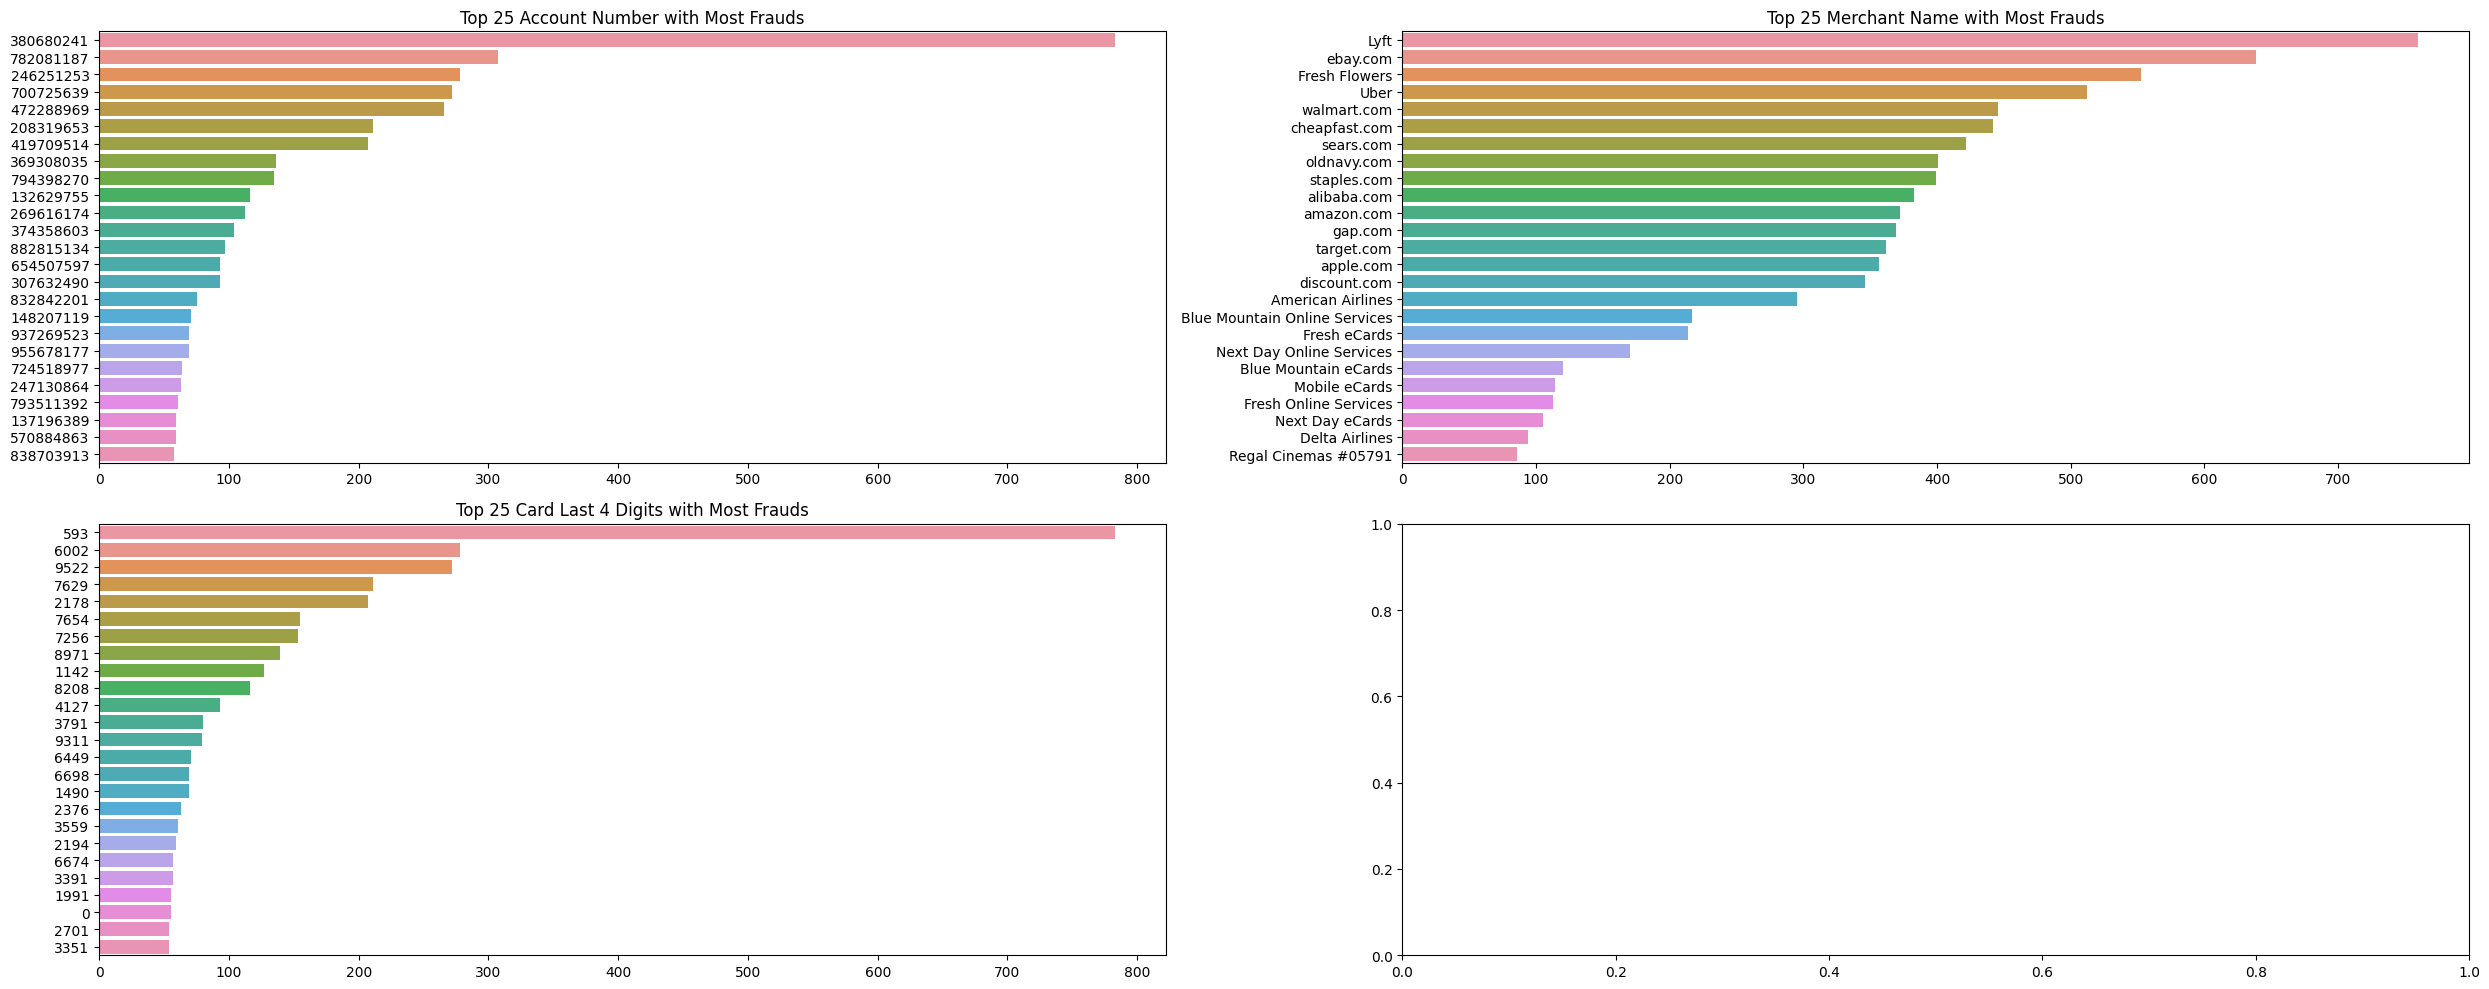

In [168]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 10))

for i in range(len(id_vars)):
    fraud_in_var = df_fraud[id_vars[i]].value_counts().head(25)
    sns.barplot(y = list(range(25)), x = fraud_in_var.values, orient='h', ax =
                axes[i%2, i//2])
    axes[i%2, i//2].set_yticks(ticks = list(range(25)), labels = fraud_in_var.index.tolist())
    axes[i%2, i//2].set_title(f'Top 25 {id_varname[i]} with Most Frauds')
fig.tight_layout()

#### 2.12 Could Anomalies in Card Digits Infer Frauds?

In Part 1, we discovered that some entries in ```cardLast4Digits``` are not actually of 4 digits. It might be helpful to see if digit anomalies are related to fraud occurrences. However, from the bar chart below, fraud occurs in digit anomalies for about 1.4 % of time (i.e. 0.002/(0.138+0.002)), and in normal digits for about 1.5% of time (0.013/(0.013+0.846)), so we did not exhibit a significant difference based on the visualization.

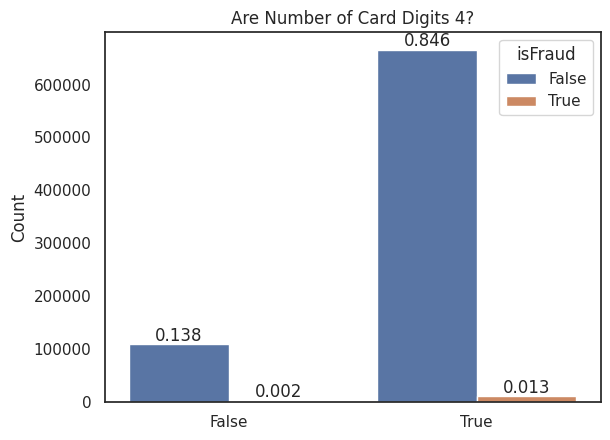

In [ ]:
df['weird_digits'] = (df['cardLast4Digits'].astype(str).str.len() == 4)

ax = sns.countplot(data=df, x='weird_digits', hue='isFraud')

for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2,
                    p.get_y() + p.get_height() + 6700,
                    round(p.get_height()/len(df),3),
                    ha="center")
ax.set_title('Are Number of Card Digits 4?')
ax.set_xlabel('')
ax.set_ylabel('Count')

#### 2.13 How about CVVs?

It would also be interesting to see if entering wrong CVVs could infer some information about frauds. From the chart below, fraud occurs in wrongly entered CVV transactions for nearly 3% of the time, while 1.5% of the time in correctly entered CVV transactions. The probability nearly doubled! This indicates that an indicator variable for CVV match might be helpful for modeling credit card frauds.

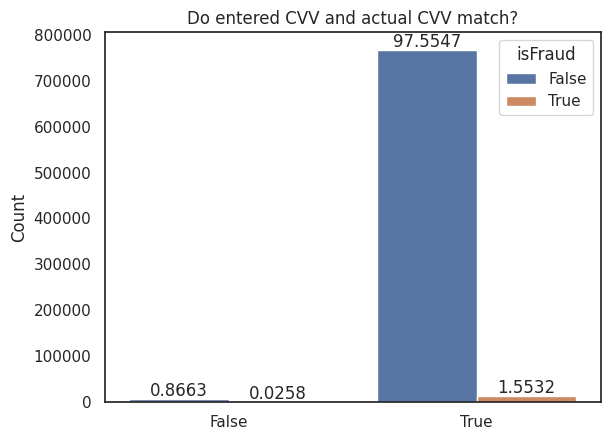

In [ ]:
df['CVV_matched'] = (df['cardCVV'] == df['enteredCVV'])

ax = sns.countplot(data=df, x='CVV_matched', hue='isFraud')

for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2,
                    p.get_y() + p.get_height() + 6700,
                    round(100*p.get_height()/len(df),4),
                    ha="center")

ax.set_title('Do entered CVV and actual CVV match?')
ax.set_xlabel('')
ax.set_ylabel('Count')

### 2.2 Visualization of Numerical Variables

#### 2.21 Univariate Analysis

For numerical variables, we first look at their individual distributions. I used both histograms and boxplots to comprehensively summarize the distributions of numerical variables.

As can be seen from the plots, ```transactionAmount```, along with ```availableMoney``` and ```currentBalance```, is heavily skewed to the right. From the boxplot, the interquartile range of ```transactionAmount``` ranges from a moderately small amount greater than 0 to lower than $250 - this structure makes sense as this is how much money we usually spend on one transaction. And outliers that skewed the distribution to the right are for those occasional large transactions for special purposes. I also plotted distributions of frauds against distributions of non-frauds in the plots below, but the distributions look similar.

Similarly, ```creditLimit```, as a discrete numerical variable, is also skewed to the right, and we can see that it has most of its entries below $10000. This reflects a very common range for credit limit that we usually have in our credit cards.

Returning back to the boxplots, we can see that there are outliers for all four numerical variables on the right end, indicating that very large amounts of money have incurred in some transactions. This also indicates that we need to be cautious about whether we want to use models that are insensitive to outliers. 

Finally, these distributions signal that we might need to conduct log transformation or other type of transformation on numerical variables if we are considering using models that require normalized data as its statistical assumption. The distributions could also signal that we could consider using models that are insensitive to outliers such as tree-based models.

In [ ]:
numeric_vars = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
numeric_varnames = ['Credit Limit', 'Available Money', 'Transaction Amount',
                    'Current Balance']
ylim_numeric = [[0, 15], [0, 3], [0, 3], [0, 4]]

colors = random.sample(default_palette, len(numeric_vars))

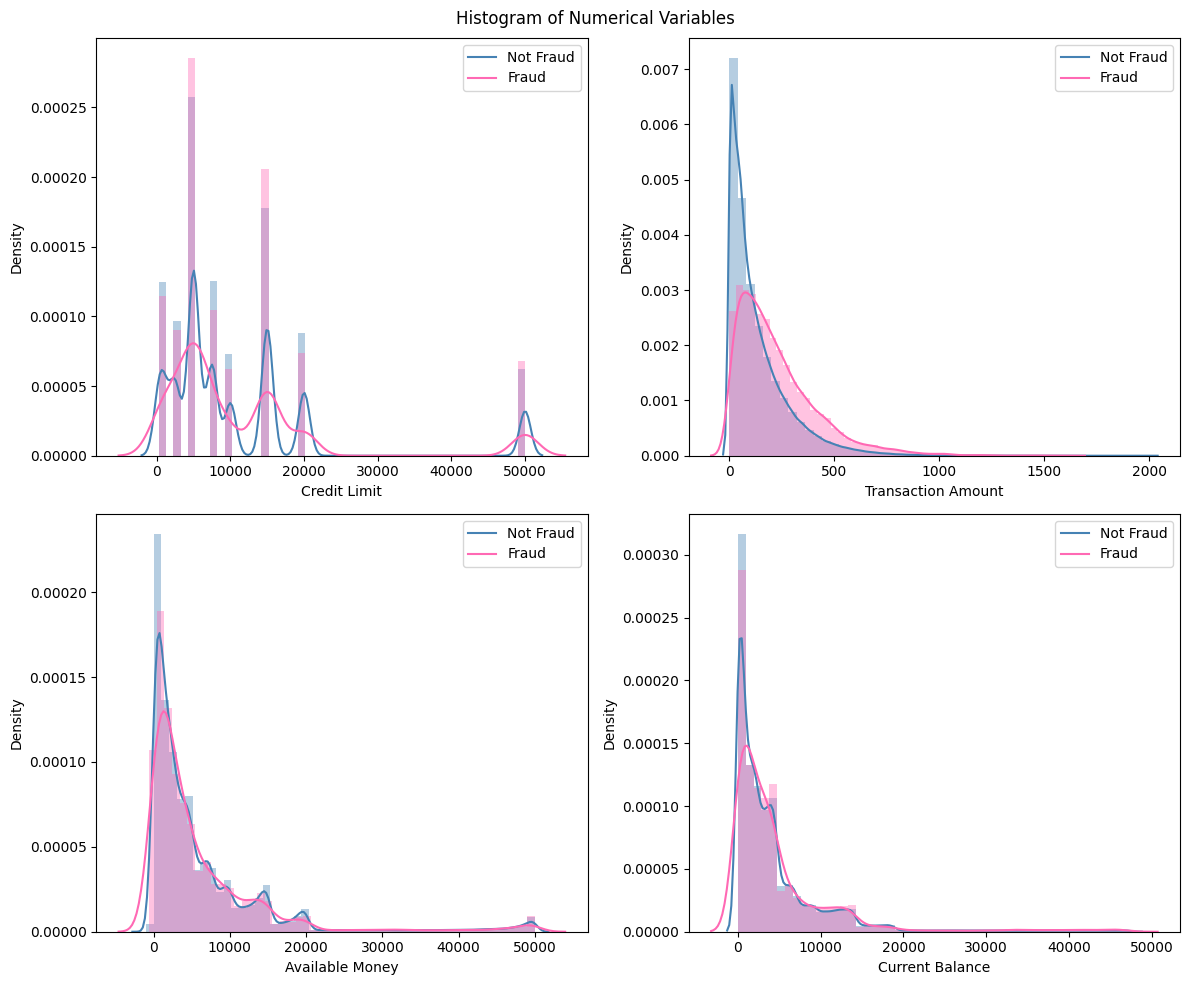

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

for i in range(len(numeric_vars)):
    sns.distplot(df_nonfraud[numeric_vars[i]], kde = True, color = 'steelblue', ax=axes[i%2, i//2])
    sns.distplot(df_fraud[numeric_vars[i]], kde = True, color = 'hotpink', ax=axes[i%2, i//2])
    axes[i%2, i//2].set_xlabel(numeric_varnames[i])
    axes[i%2, i//2].legend(labels=['Not Fraud', 'Fraud'])
    # axes[i%2, i//2].set_ylabel('Percent')
    # axes[i%2, i//2].set_ylim(ylim_numeric[i])

plt.suptitle('Histogram of Numerical Variables')
fig.subplots_adjust(top = 0.95)
fig.tight_layout()

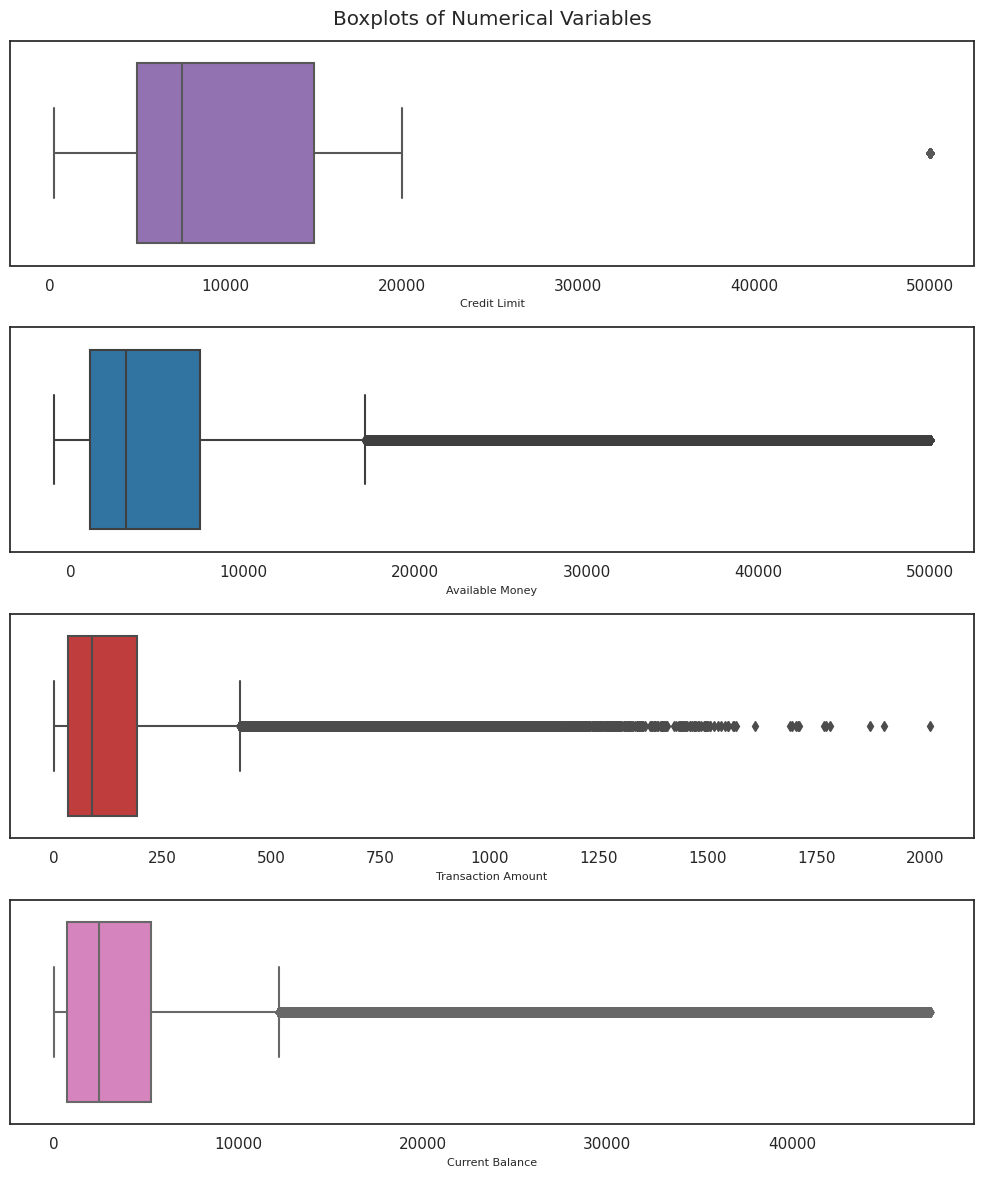

In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (10, 12))

for i in range(len(numeric_vars)):
    sns.boxplot(data = df, x = numeric_vars[i], color = colors[i], ax = axes[i])
    axes[i].set_xlabel(numeric_varnames[i], fontsize = 8)
    axes[i].set_ylabel('')
plt.suptitle('Boxplots of Numerical Variables')
fig.subplots_adjust(top = 0.95)
fig.tight_layout()

#### 2.22 Multivariate Analysis

We are interested in how the numerical variables are correlated with each other, since high level of correlations suggests that the model might have multicollinearity issues - if so, we would need to reduce data dimensions or to select the appropriate model to prevent overfitting issues in Part 4.

Based on the scatterplot below, we see that ```creditLimit``` exhibit salient relation with ```availableMoney``` and ```currentBalance``` - the more credit limit, the more mean value of available money and current balance (this makes intuitive sense), and the variation in spending and balance increases by credit limit as well. An improvement that could be made to test this hypothesis formally (if time allows) is to conduct an ANOVA here.


We also see that current balance and available money exhibit very strong negative relationship, likely segmented by credit limit - the lower the current balance, the more the available money. This again makes intuitive sense because technically available money = credit limit - current balance.

Due to this linear relationship formed by the three variables, we would need to either conduct feature selection or select the appropriate model in Part 4 to especially deal with this issue.

```transactionAmount``` scatters in a fairly random way with the three variables above and appear independent of them. In regards to our target fraud variable, we see that a similar wide range of values span in both frauds and non-frauds, so it does not appear that fraud is strongly correlated with the numerical variables.

Text(0.5, 0.98, 'Scatterplot between Numerical Variables')

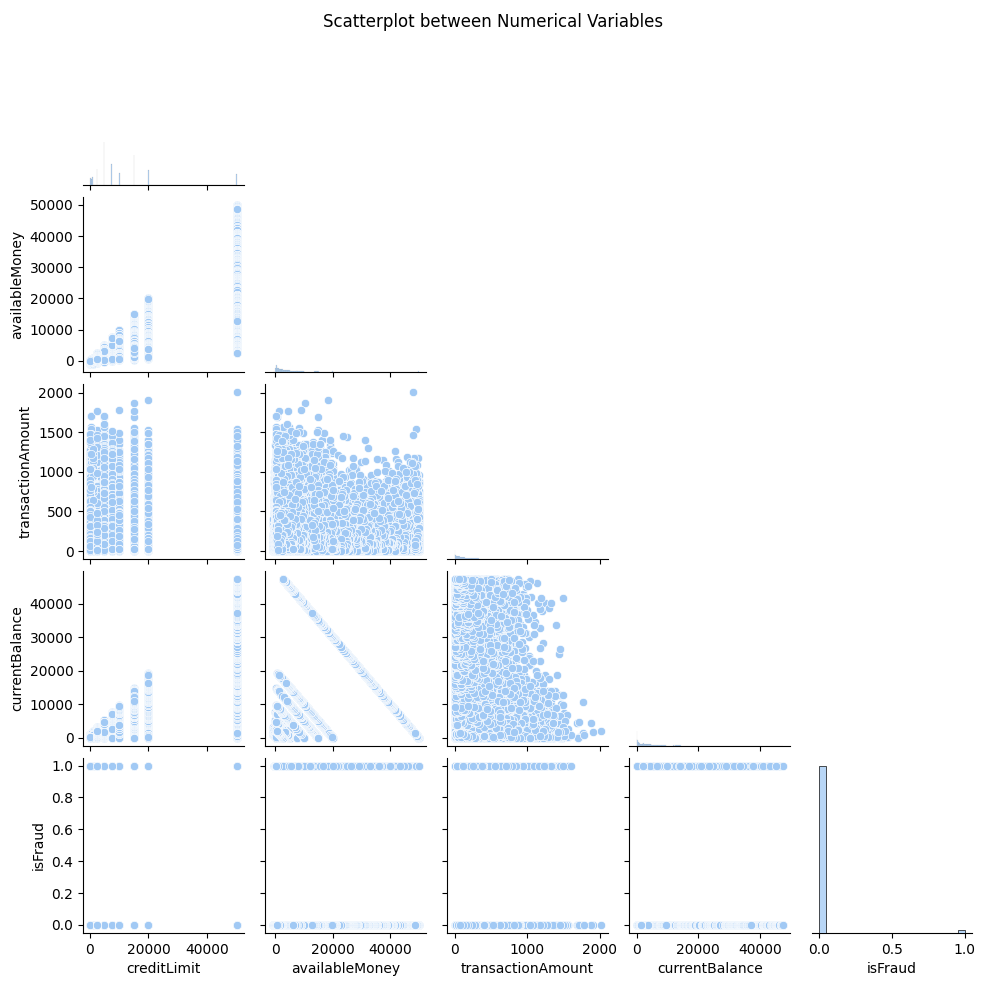

In [ ]:
numeric_vars_multi = numeric_vars.copy()
numeric_vars_multi.append('isFraud')
g = sns.pairplot(df[numeric_vars_multi], height = 2, corner=True)
g.fig.suptitle("Scatterplot between Numerical Variables")

### 2.3 Visualization of Binary and Categorical Variables

We are interested in seeing how our data is distributed across categories, for both fraud transactions and non-fraud transactions.

Firstly, we show the number of non-fraud transactions across categories. We see that more non-fraud transactions do not have a card present (i.e., online transactions), do not have expiration date/key matched, occur predominantly in the U.S., have POS mode and POS condition of 5 and 1 respectively, have online retail / fast food / entertainment as the three most frequent categories, and have purchase as the predominant transaction type.

We exhibit somewhat similar trends for fraudulent transactions. Yet the exceptions are that: the gap between card-not-present transactions and card-present transactions widened, meaning that there are significantly more online transactions compared to credit-card-present transactions for frauds. The most common POS entry mode has changed to 9. Finally, online shopping in fraud transactions seem to be much more frequent, with online gift and rideshare then being the second and third most frequent merchant types.

These differences suggest that ```cardPresent```, ```posEntryMode```, and ```merchantCategoryCode``` might be very useful variables that could be used in the modeling section to differentiate between frauds and non-frauds.

In [ ]:
categorical_vars = ['cardPresent', 'expirationDateKeyInMatch',
                    'acqCountry', 'merchantCountryCode', 'posEntryMode',
                    'posConditionCode', 'merchantCategoryCode', 'transactionType']

categorical_varname = ['Is Card Present?', 'Is Expiration Date/Key Matched?',
                       'Country', 'Merchant Country', 'POS Entry Mode', 'POS Condition',
                       'Merchant Category', 'Transaction Type']

colors_other = random.sample(default_palette, len(categorical_vars))

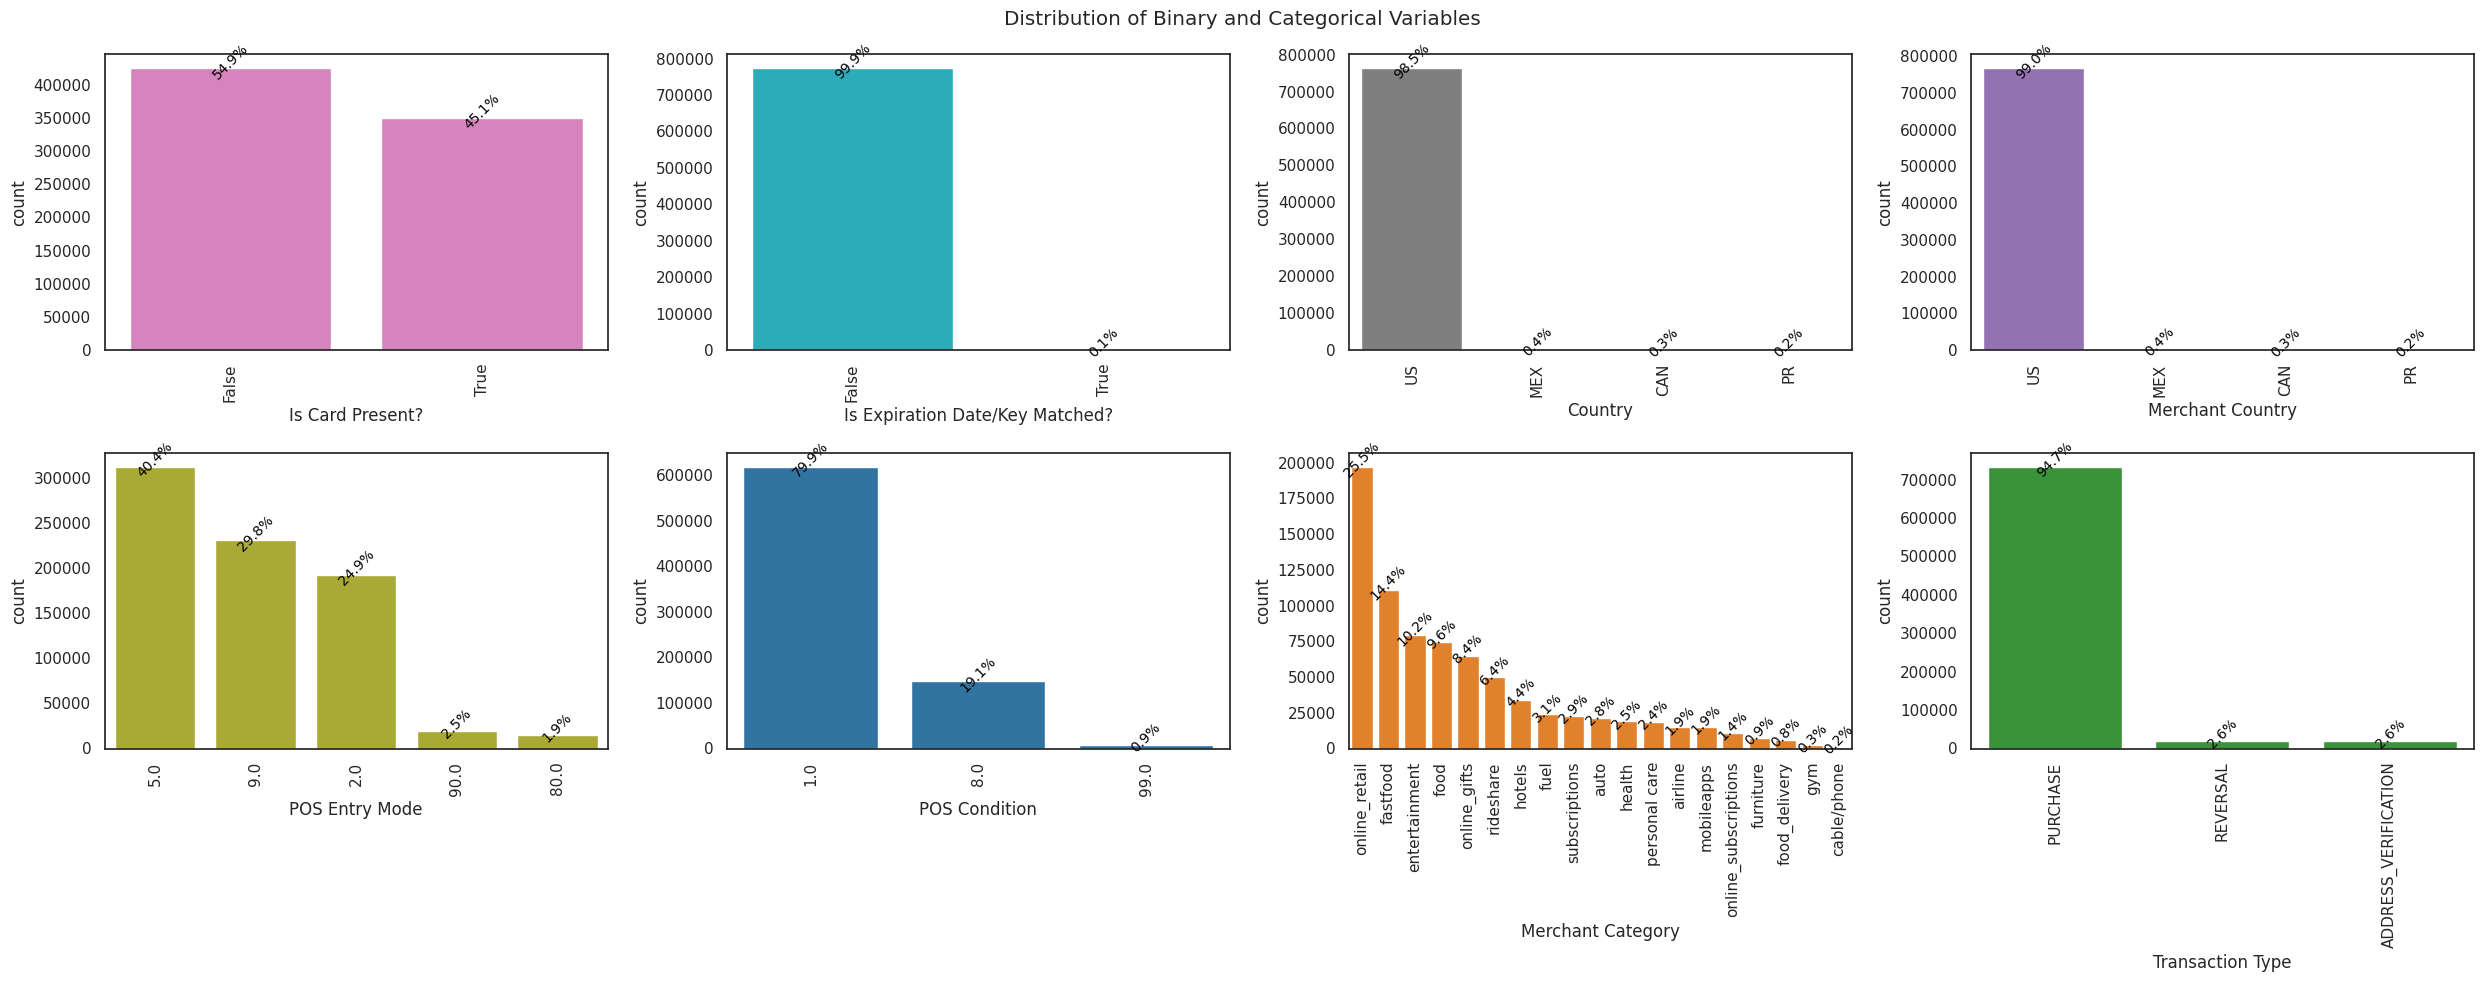

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (25, 10))

for i in range(len(categorical_vars)):

    sns.countplot(data = df_nonfraud, x = categorical_vars[i], color = colors_other[i],
                  ax =axes[i//4, i%4], order = df[categorical_vars[i]].value_counts()
                  .index)

    axes[i//4, i%4].set_xlabel(categorical_varname[i])
    axes[i//4, i%4].tick_params(axis='x', rotation=90)

    for p in axes[i//4, i%4].patches:
      percentage = '{:.1f}%'.format(100 * p.get_height() / len(df_nonfraud))
      axes[i//4, i%4].annotate(f'{percentage}', (p.get_x()
       + p.get_width() / 2., p.get_height()), ha='center', va='center',
                                fontsize=10, color='black', xytext=(0,5),
                                textcoords='offset points', rotation = 45)

plt.suptitle('Distribution of Binary and Categorical Variables')
fig.subplots_adjust(top = 0.95)
fig.tight_layout()

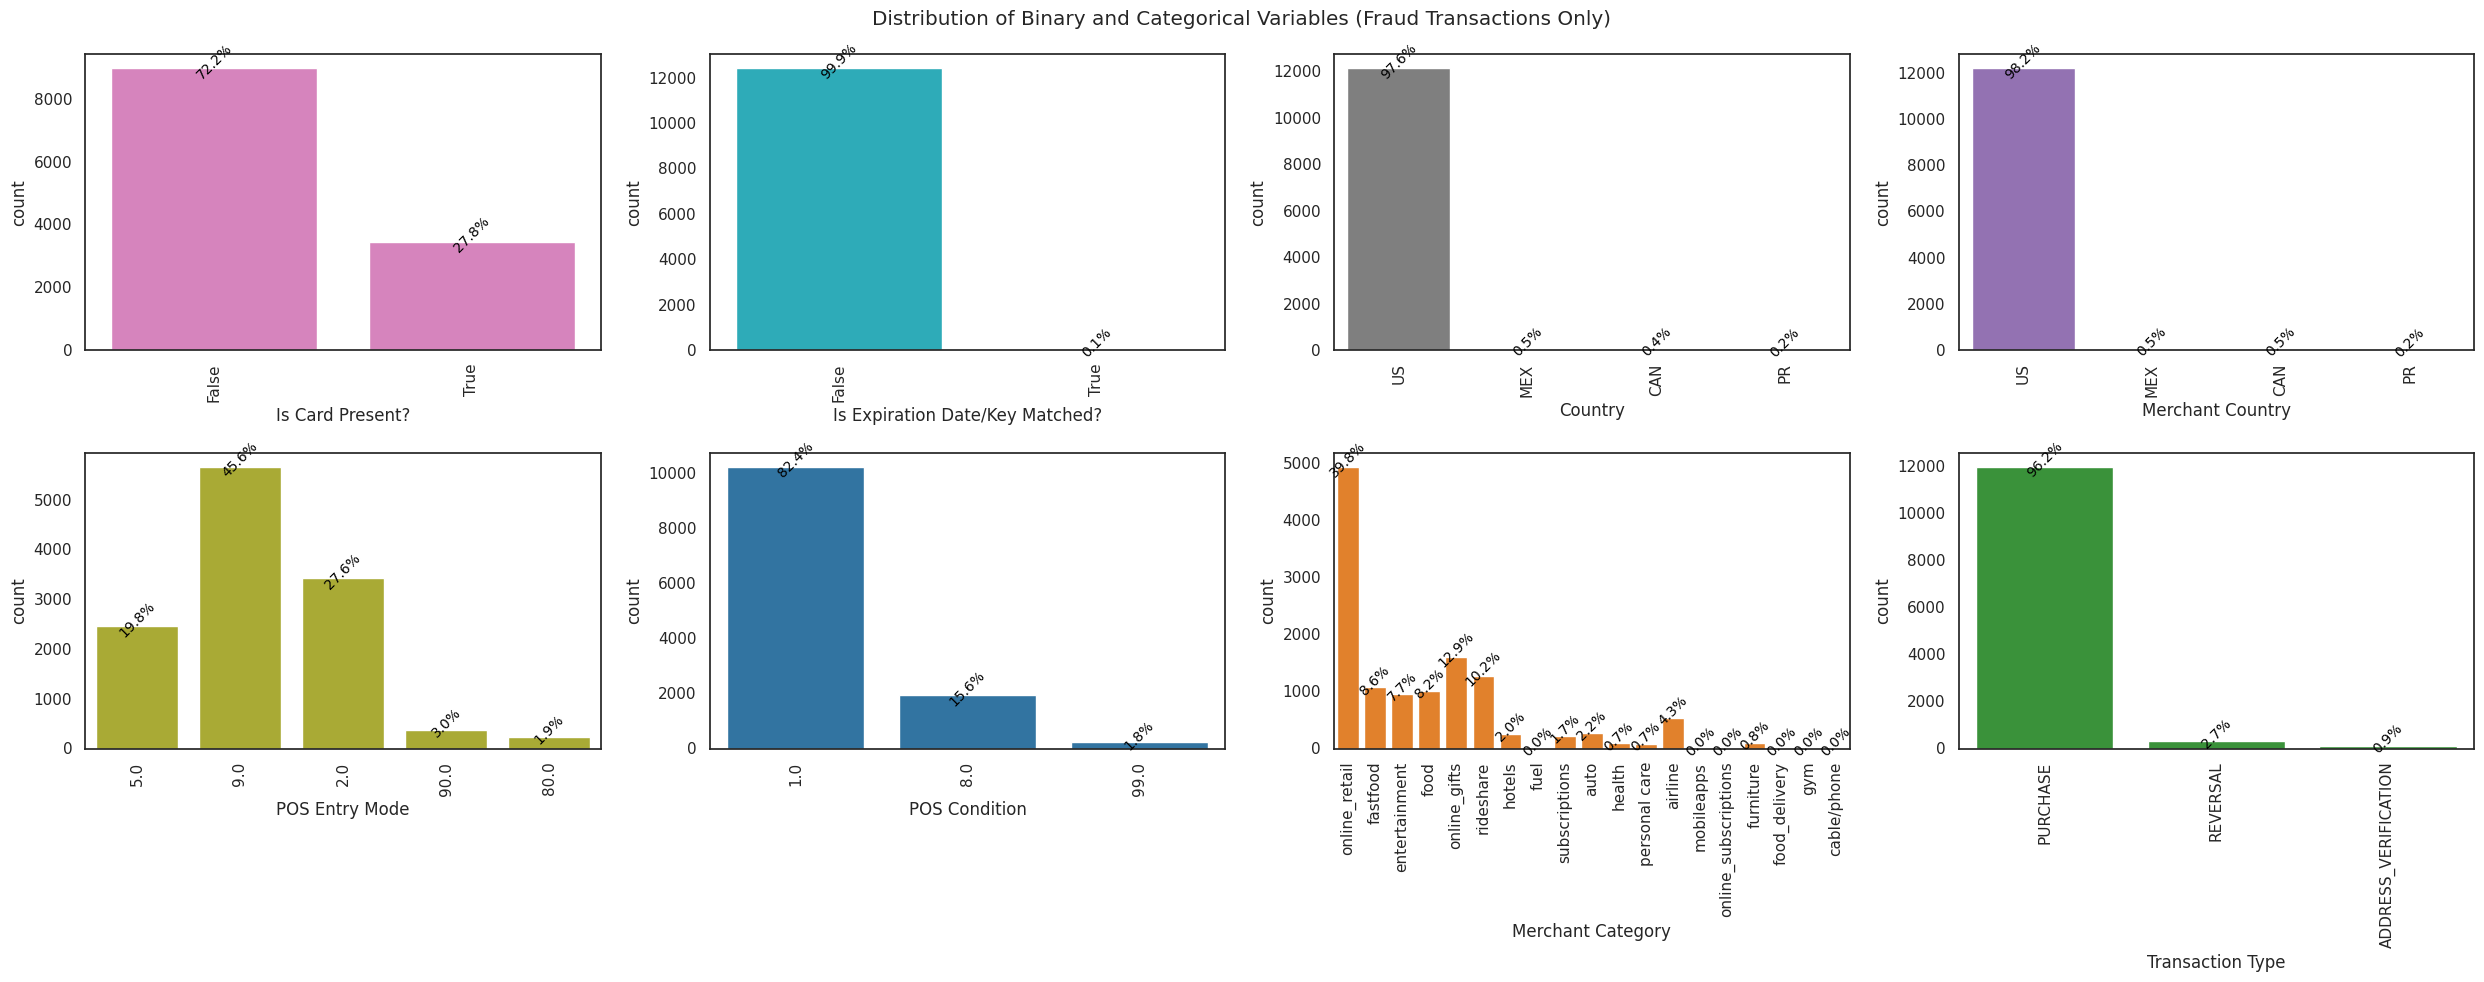

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (25, 10))

for i in range(len(categorical_vars)):

    sns.countplot(data = df_fraud, x = categorical_vars[i], color = colors_other[i],
                  ax =axes[i//4, i%4], order = df[categorical_vars[i]].value_counts()
                  .index)

    axes[i//4, i%4].set_xlabel(categorical_varname[i])
    axes[i//4, i%4].tick_params(axis='x', rotation=90)

    for p in axes[i//4, i%4].patches:
      percentage = '{:.1f}%'.format(100 * p.get_height() / len(df_fraud))
      axes[i//4, i%4].annotate(f'{percentage}', (p.get_x()
       + p.get_width() / 2., p.get_height()), ha='center', va='center',
                                fontsize=10, color='black', xytext=(0,5),
                                textcoords='offset points', rotation = 45)

plt.suptitle('Distribution of Binary and Categorical Variables (Fraud Transactions Only)')
fig.subplots_adjust(top = 0.95)
fig.tight_layout()

### 2.4 Visualization of Timestamp Variables

Do timestamp variables contribute any useful inference to detecting fraud? We can see that the time series for number of frauds over transaction date and current expiration resemble white noise, signaling that fraud might not have salient trends over these two dates.

Meanwhile, number of frauds do exhibit some trends for account opening date and date of last address changed (peaking around 2014/2015 for account opening date and around 2016 for date of last address changed), suggesting that they might be useful to differentiate between frauds and no frauds, although the high volatility exhibited here are still concerning.

In [ ]:
# Construct a list of timestamp variables
date_vars = ['transactionDateTime', 'currentExpDate', 'accountOpenDate',
             'dateOfLastAddressChange']
date_varname = ['Transaction Date', 'Current Expiration Date', 'Account Opening Date',
                'Date of Last Address Change']

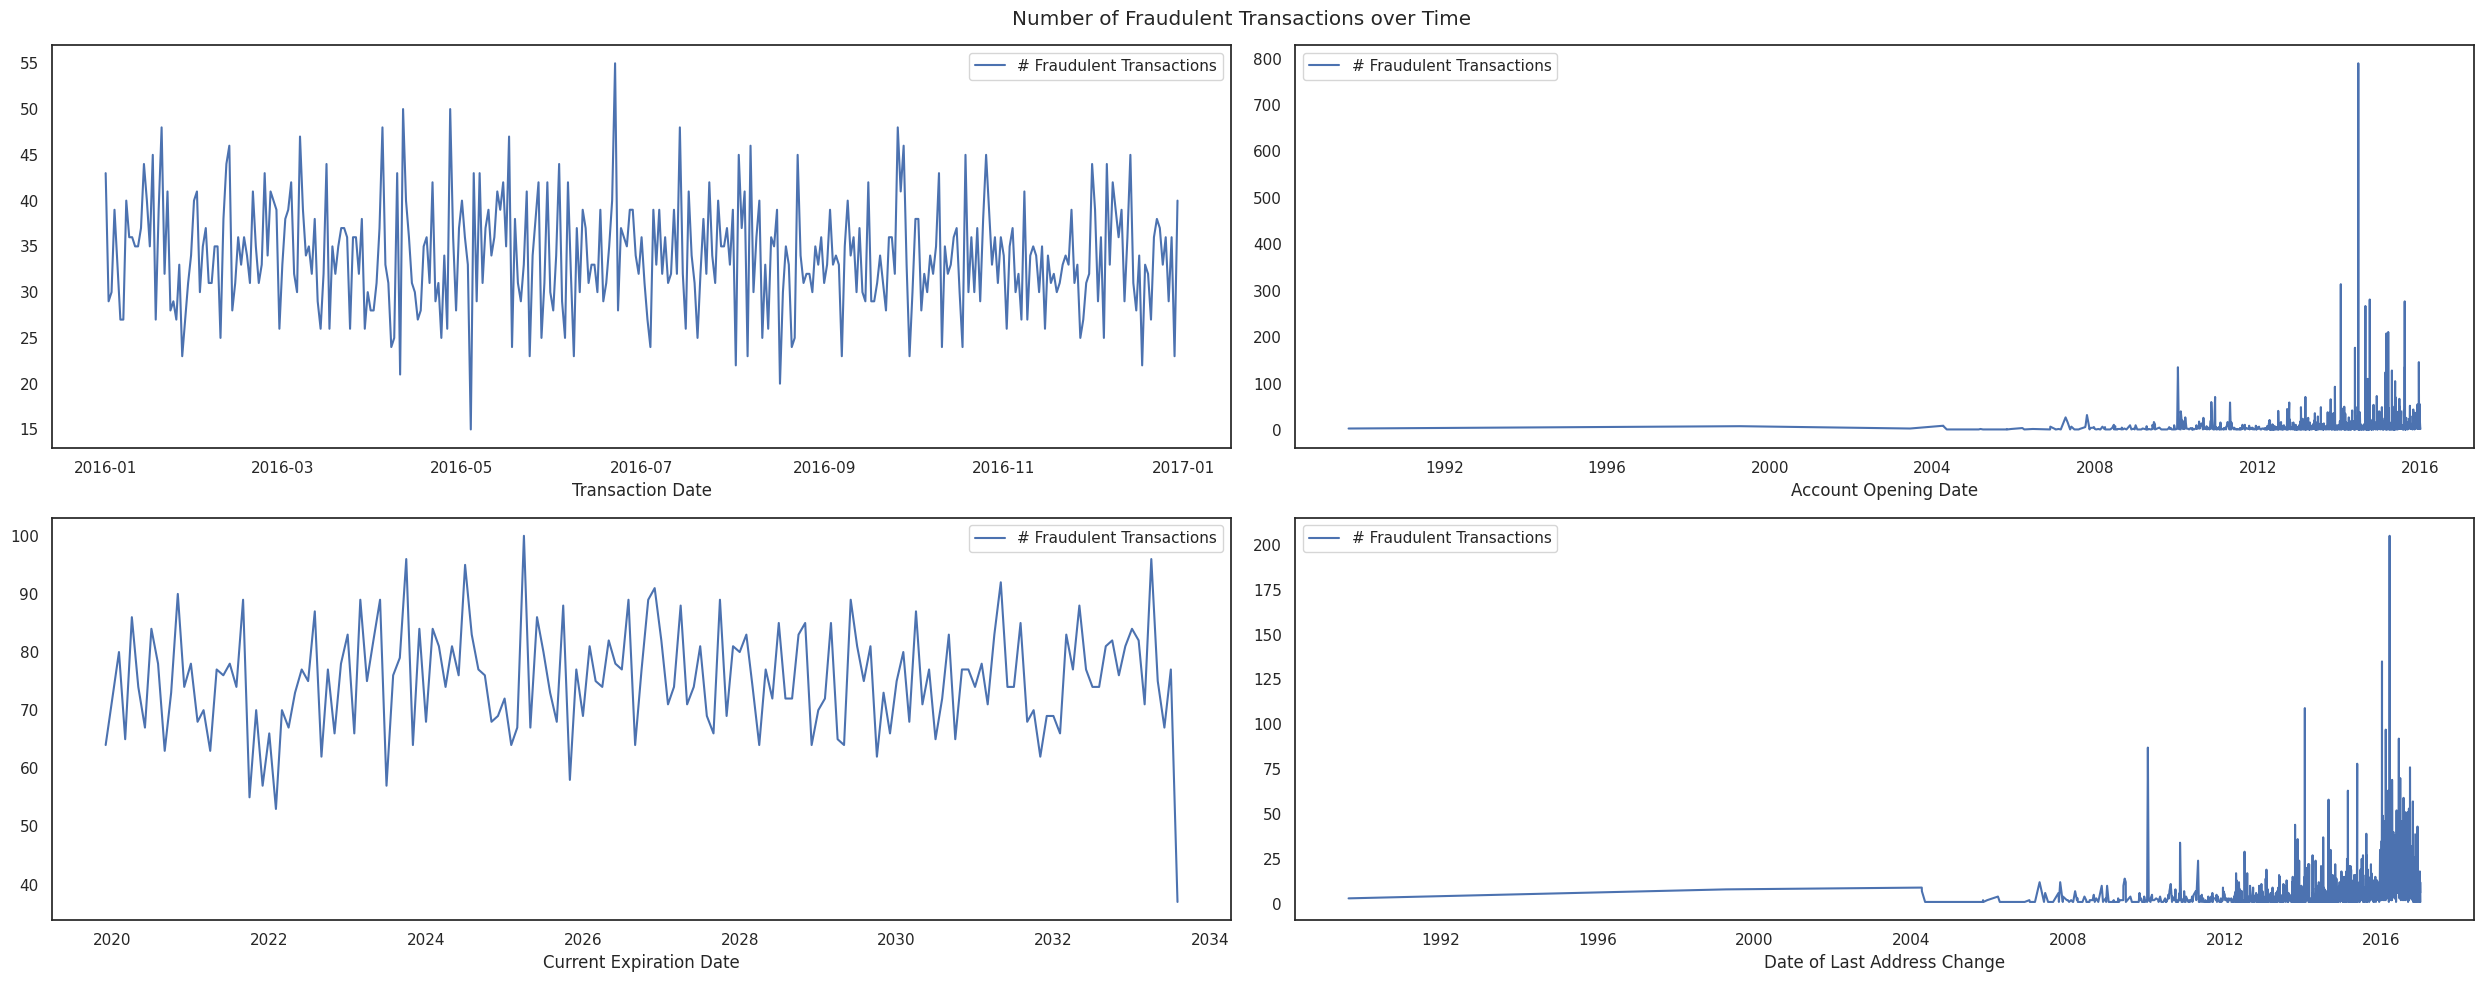

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 10))

for i in range(len(date_vars)):
  df_fraud[f'{date_vars[i]}_new'] = pd.to_datetime(df_fraud[date_vars[i]]).dt.date
  df_ts = pd.DataFrame(df_fraud.groupby(f'{date_vars[i]}_new')['accountNumber'].
                       count()).rename(columns =
                        {'accountNumber' :'# Fraudulent Transactions'})
  sns.lineplot(df_ts, ax = axes[i%2, i//2])
  axes[i%2, i//2].set_xlabel(date_varname[i])

plt.suptitle('Number of Fraudulent Transactions over Time')
fig.subplots_adjust(top = 0.95)
fig.tight_layout()

In [ ]:
# * Change file path to your directory if necessray *
df.to_csv('transactions_part2_processed.csv', index = False)

## **Part 3: Data Wrangling - Duplicate Transactions**

In this section, we make assumptions to identify two types of duplicated transactions, reversed transactions and multi-swipe transactions.

So, loading data for duplicated transactions:

In [ ]:
# *Change the file path to your file directory if necessary*
file_path = 'transactions_part2_processed.csv'

# Load processed data from part 2
df = pd.read_csv(file_path)

### 3.1 Reversed Transaction

One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Based on this information, we can deduce some assumptions such as:

1. one purchase should be followed with only one reversal

2. the ```transactionDateTime``` of the reversal should be later than that of purchase

3. ```trasactionAmount``` should be the same for the purchase and the reversal

4. Personal and merchant information should be the same for the purchase and the reversal

Under these assumptions, I took the following steps to identify reversed transactions:

1. Save the index of each entry as ```transaction_id``` to identify unique transaction instances.

2. Select rows with the same ```accountNumber```, ```transactionAmount``` and ```merchantName``` - Note that we have proved in Part 1 that ```accountNumber``` is the same as ```customerId```, so we only need one of these two to select relevant rows.

3. Create 2 datasets, one only containing purchases (```transactionType == 'PURCHASE'```) and one only containing reversals (```transactionType == 'REVERSAL'```).

4. Inner join the 2 datasets by ```accountNumber```, ```transactionAmount```, and ```merchantName```.

5. Select rows where ```transactionDateTime``` of purchase is earlier than that of reversal.

6. Make sure that only one purchase transaction is matched with one reversal transaction by keeping only one entry per (```transaction_id``` of purchase, ```transaction_id``` of reversal) pair. Assume that the reversal follows the purchase closely, so keep the one with the smallest time difference between purchase and reversal. Note that since the data are matched so that transaction amount stays the same, doing so will not have additional effect on total transaction amount aside from removing the effects of redundant matches on total transaction amount.

In [ ]:
# Assign an identifier to each transaction
df.sort_values(['accountNumber', 'transactionDateTime'], inplace = True)
df['transaction_id'] = df.index

In [ ]:
# Create a list of date-time variables to transform
datetime_vars = ['transactionDateTime', 'currentExpDate', 'accountOpenDate',
                 'dateOfLastAddressChange']

# Transform date-time variables to standardized formats
for var in datetime_vars:
  df[var] = pd.to_datetime(df[var])

# Find transactions with same personal and merchant information
same_info = df[df.duplicated(['accountNumber', 'transactionAmount', 'merchantName'], keep=False)]

# Subset datasets into purchases and reversals
purchases = same_info[same_info['transactionType'] == 'PURCHASE']
reversals = same_info[same_info['transactionType'] == 'REVERSAL']

# Join the 2 datasets by specified columns
reversed_trans = pd.merge(purchases, reversals, on=['accountNumber',
                                                    'transactionAmount', 'merchantName'])

# Reversed transactions are those whose transaction date is later than the first transaction date
reversed_trans = reversed_trans[reversed_trans['transactionDateTime_x'] <
                                reversed_trans['transactionDateTime_y']]

# When there are many-to-one matches, I take the earliest time
reversed_trans['time_diff'] = reversed_trans['transactionDateTime_y'] - reversed_trans[
    'transactionDateTime_x']

# Reversals are matched multiple times, hence filter the closest reversal to original transaction
reversed_trans.sort_values(by = ['transaction_id_y', 'time_diff'], ascending=True, inplace = True)
unique_reversed_trans = pd.DataFrame(reversed_trans.groupby(['transaction_id_y']).
                                     agg({'time_diff':'min', 'transactionAmount':'first', 
                                          'transaction_id_x': 'first'})).reset_index()
unique_reversed_trans = pd.merge(reversed_trans, unique_reversed_trans[['transaction_id_x', 'transaction_id_y']], 
                                 on = ['transaction_id_x','transaction_id_y'])

Through our subsetting condition, we already excluded the first transaction. Hence, we estimate that the total number of reversed transactions is 17759 and the total dollar amount is $2666519.27.

In [ ]:
print(f'''Total number of reversed transaction:
{len(unique_reversed_trans)}\n''')

print(f'''Total dollar amount for reversed transaction:
{unique_reversed_trans['transactionAmount'].sum()}''')

Total number of reversed transaction:
17759

Total dollar amount for reversed transaction:
2666519.27


### 3.2 Multi-Swipe Transactions

Another type of duplicated transaction is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span. Based on this information, we can deduce that:

1. there should be multiple purchases associated with one ```transactionAmount```, personal information, merchant information, and transaction type.

2. the ```transactionDateTime``` of the multiple purchases should be within a short timeframe. I have set this timeframe to be 50 minutes - since the multi-swipe transaction is caused by accident, it is difficult to imagine that two swipes would occur more than 50 minutes, and the reason why I did not set the timeframe shorter to, say, 5 minutes, is because from my personal experience, sometimes there is a delay in recording transactions on the credit balance, so transaction time is not always accurate. 

3. the transactions should be made in a consecutive manner, after controlling for all information in assumption 1.

With these 2 criteria, to filter all multi-swipe transactions:

1. Select rows with the same ```accountNumber```, ```transactionAmount```, ```merchantName```, and ```transactionType```

2. Select rows where ```transactionType``` is ```'PURCHASE'```

3. Group purchases based on personal and merchant information, and calculate the time difference within the group

4. In the same group, calculate the difference in ```transactionId```.

4. Select rows where the time difference is less than 5 minutes and ID difference is 1.


In [ ]:
same_info2 = df[df.duplicated(['accountNumber', 'merchantName', 'transactionAmount',
                               'transactionType'],keep=False)]

# Select purchasing transactions and sort the purchasing data by transactionDateTime
purchase2 = same_info2[same_info2.transactionType == 'PURCHASE']

purchase2.sort_values(by = ['accountNumber', 'merchantName', 'transactionDateTime']
                      , ascending=True, inplace = True)

# Calculate the time difference between current row and previous row
def get_time_diff(data):
  """Calculate the difference between transaction id and transaction time between
  current row and previous row"""
  data['time_diff'] = data['transactionDateTime'].diff(1).dt.total_seconds()
  data['index_diff'] = data['transaction_id'].diff(1)
  return data

# Calculate time and id difference within the same group
multi_trans = purchase2.groupby(['accountNumber', 'merchantName',
                                 'transactionAmount']).apply(get_time_diff)

# Select rows where time difference is smaller than 5 minutes, and index difference
# is 1 (to ensure consecutiveness)
multi_trans_final = multi_trans[(multi_trans['time_diff'] <= 3000) & (multi_trans['index_diff'] == 1)]

Through our subsetting condition, we already excluded the first transaction - the first transaction will have a ```time_diff``` as ```NaN``` and ```index_diff``` as ```NaN```. Hence, we estimate that the total number of multi-swipe transactions is 7334 and the total dollar amount is $1085394.12.

In [ ]:
print(f'''Total number of multi-swipe transaction:
{len(multi_trans_final)}\n''')

print(f'''Total dollar amount for multi-swipe transaction:
{multi_trans_final['transactionAmount'].sum()}''')

Total number of multi-swipe transaction:
7334

Total dollar amount for multi-swipe transaction:
1085394.12


### 3.3 Insights Gained

A natural question to ask is: should we remove multi-swipe and duplicate transactions? Or should we keep them in our data? We can evaluate this dilemma by restating our goal: fraud detection. We will keep the duplicated transactions if they are useful for prediction. To check this preliminarily, we can check the percentage of frauds in reversed transactions and in multi-swipe transactions, as shown below.

It appears that the proportion is very similar to what we exhibited in the original data, and this suggests that the percentage of frauds across reversed transactions, multi-swipe transactions, and other transactions are very similar, since the averaged percentage is similar to the group percentage. That is to say, duplicated transactions might not be an informative signal for detecting frauds. (An improvement that can be made here is to actually validate this hypothesis by 1. chi-squared test: does the observed distribution happen by chance?, or 2. both modeling with duplicates and modeling without duplicates, and compare the accuracy and F1 score). For the current time being, I have decided to delete the duplicate transactions to improve data quality.

In [ ]:
print("Fraud Frequency for Reversed Transactions")
c1 = unique_reversed_trans['isFraud_x'].value_counts(dropna=False)
p1 = unique_reversed_trans['isFraud_x'].value_counts(dropna=False, normalize=True)
final_table1 = pd.concat([c1,p1], axis=1, keys=['Counts', 'Percentage'])
print(final_table1)

Fraud Frequency for Reversed Transactions
           Counts  Percentage
isFraud_x                    
False       17456    0.982938
True          303    0.017062


In [ ]:
print("Fraud Frequency for Multi-Swipe Transactions")
c2 = multi_trans_final['isFraud'].value_counts(dropna=False)
p2 = multi_trans_final['isFraud'].value_counts(dropna=False, normalize=True)
final_table2 = pd.concat([c2,p2], axis=1, keys=['Counts', 'Percentage'])
print(final_table2)

Fraud Frequency for Multi-Swipe Transactions
         Counts  Percentage
isFraud                    
False      7209    0.982956
True        125    0.017044


That said, before deleting them, it would be interesting to see when and where would the duplicated transactions take place.

To get the "when", I plotted reversed transactions and multi-swipe transactions over hours of a day, and have discovered that fraudulent reversed transactions occur the most at 3 am, followed by 10 am, 0 am, and 10 pm. Meanwhile, fraudulent multi-swipe transactions occur more at 8 am, 10 pm, 6 am, and 1 am. The distribution of non-fraudulent transactions for reversals and multi-swipe appear quite even.  

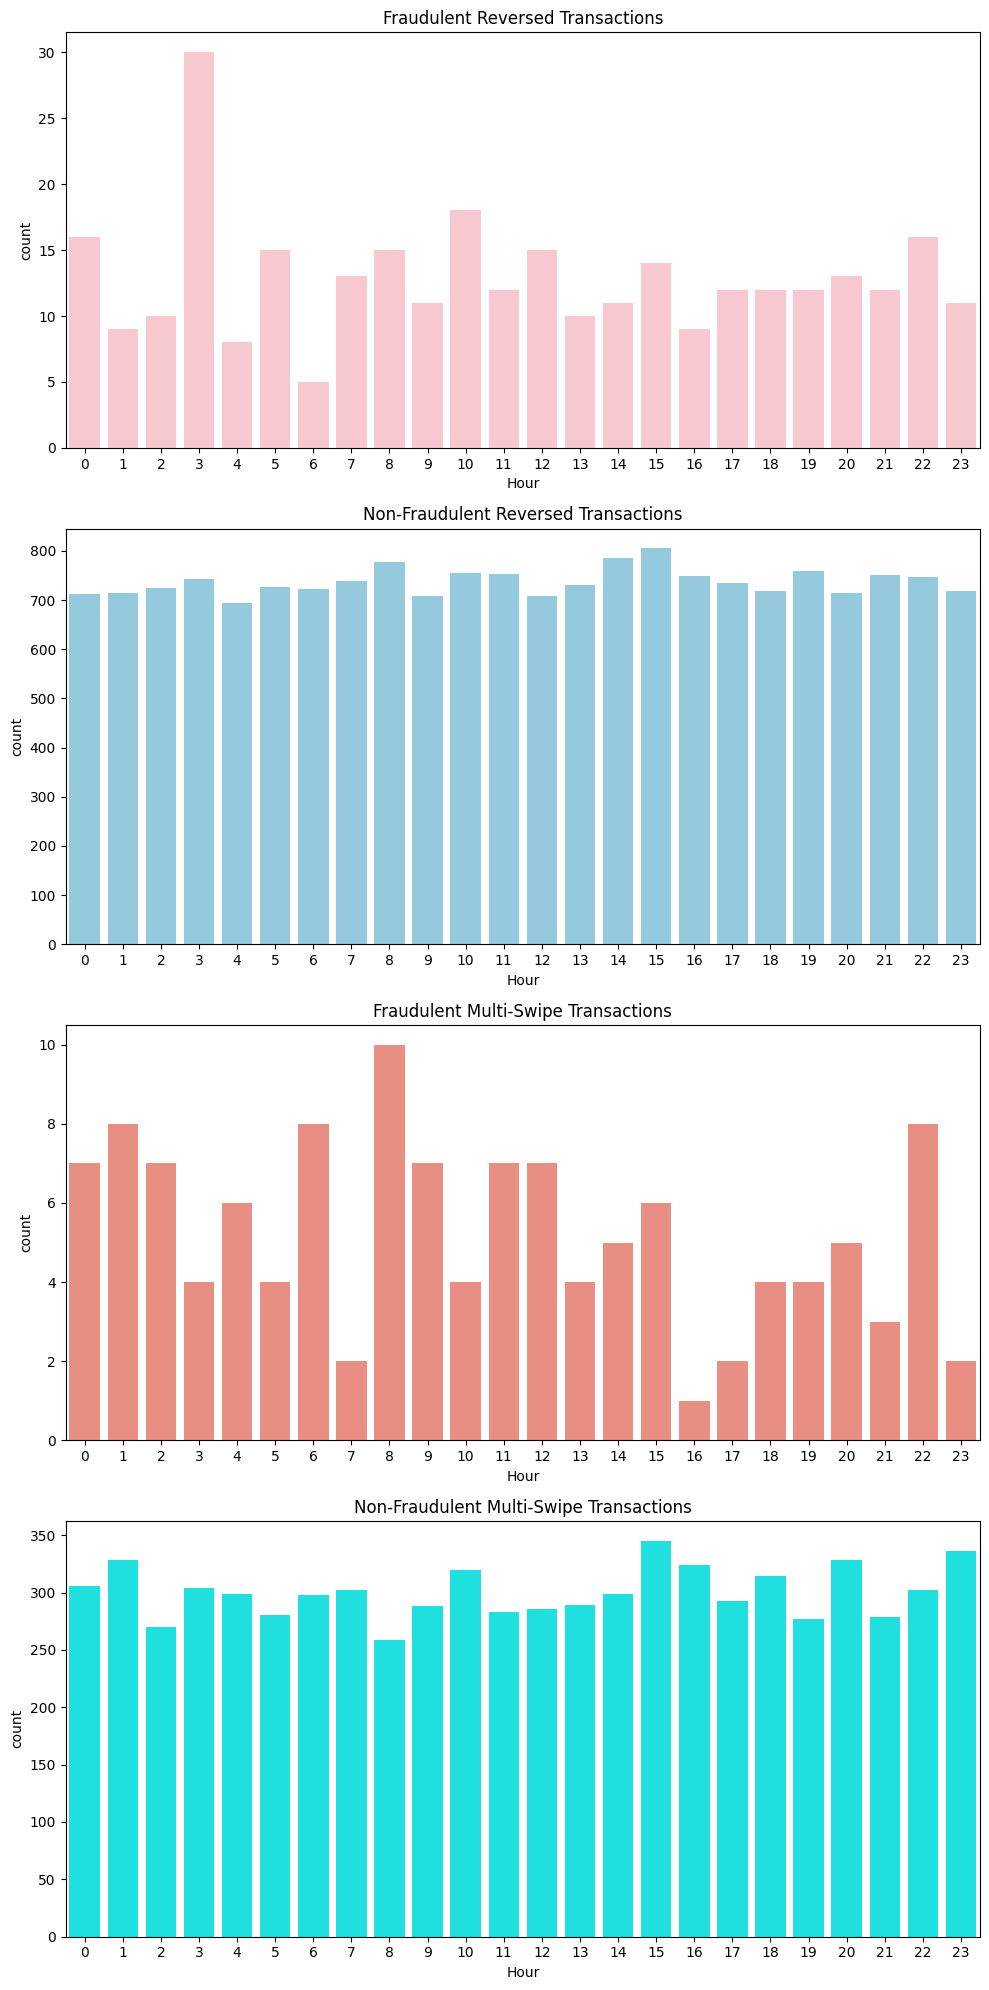

In [ ]:
reversed_trans['Hour'] = reversed_trans['transactionDateTime_y'].dt.hour
multi_trans_final['Hour'] = multi_trans_final['transactionDateTime'].dt.hour

fig, axes = plt.subplots(4, 1, figsize=(10, 20))

sns.countplot(data = reversed_trans[reversed_trans['isFraud_y'] == True],
              x= 'Hour', color="pink", ax=axes[0])
axes[0].set_title("Fraudulent Reversed Transactions")

sns.countplot(data = reversed_trans[reversed_trans['isFraud_y'] == False],
              x= 'Hour', color="skyblue", ax=axes[1])
axes[1].set_title("Non-Fraudulent Reversed Transactions")

sns.countplot(data = multi_trans_final[multi_trans_final['isFraud'] == True],
              x= 'Hour', color="salmon", ax=axes[2])
axes[2].set_title("Fraudulent Multi-Swipe Transactions")

sns.countplot(data = multi_trans_final[multi_trans_final['isFraud'] == False],
              x= 'Hour', color="aqua", ax=axes[3])
axes[3].set_title("Non-Fraudulent Multi-Swipe Transactions")

fig.tight_layout()

To get the "where", I plotted reversed and multi-swipe transactions over merchant categories, and it can be seen that their distributions are quite similar: both fraudulent and non-fraudulent reversed / multi-swipe transactions show a peak in the online retail category while having slightly different but overall similar distributions over other categories, suggesting that fraudulent transactions may not differ that much in merchant type from non-fraudulent transactions for both types of duplicated transactions.

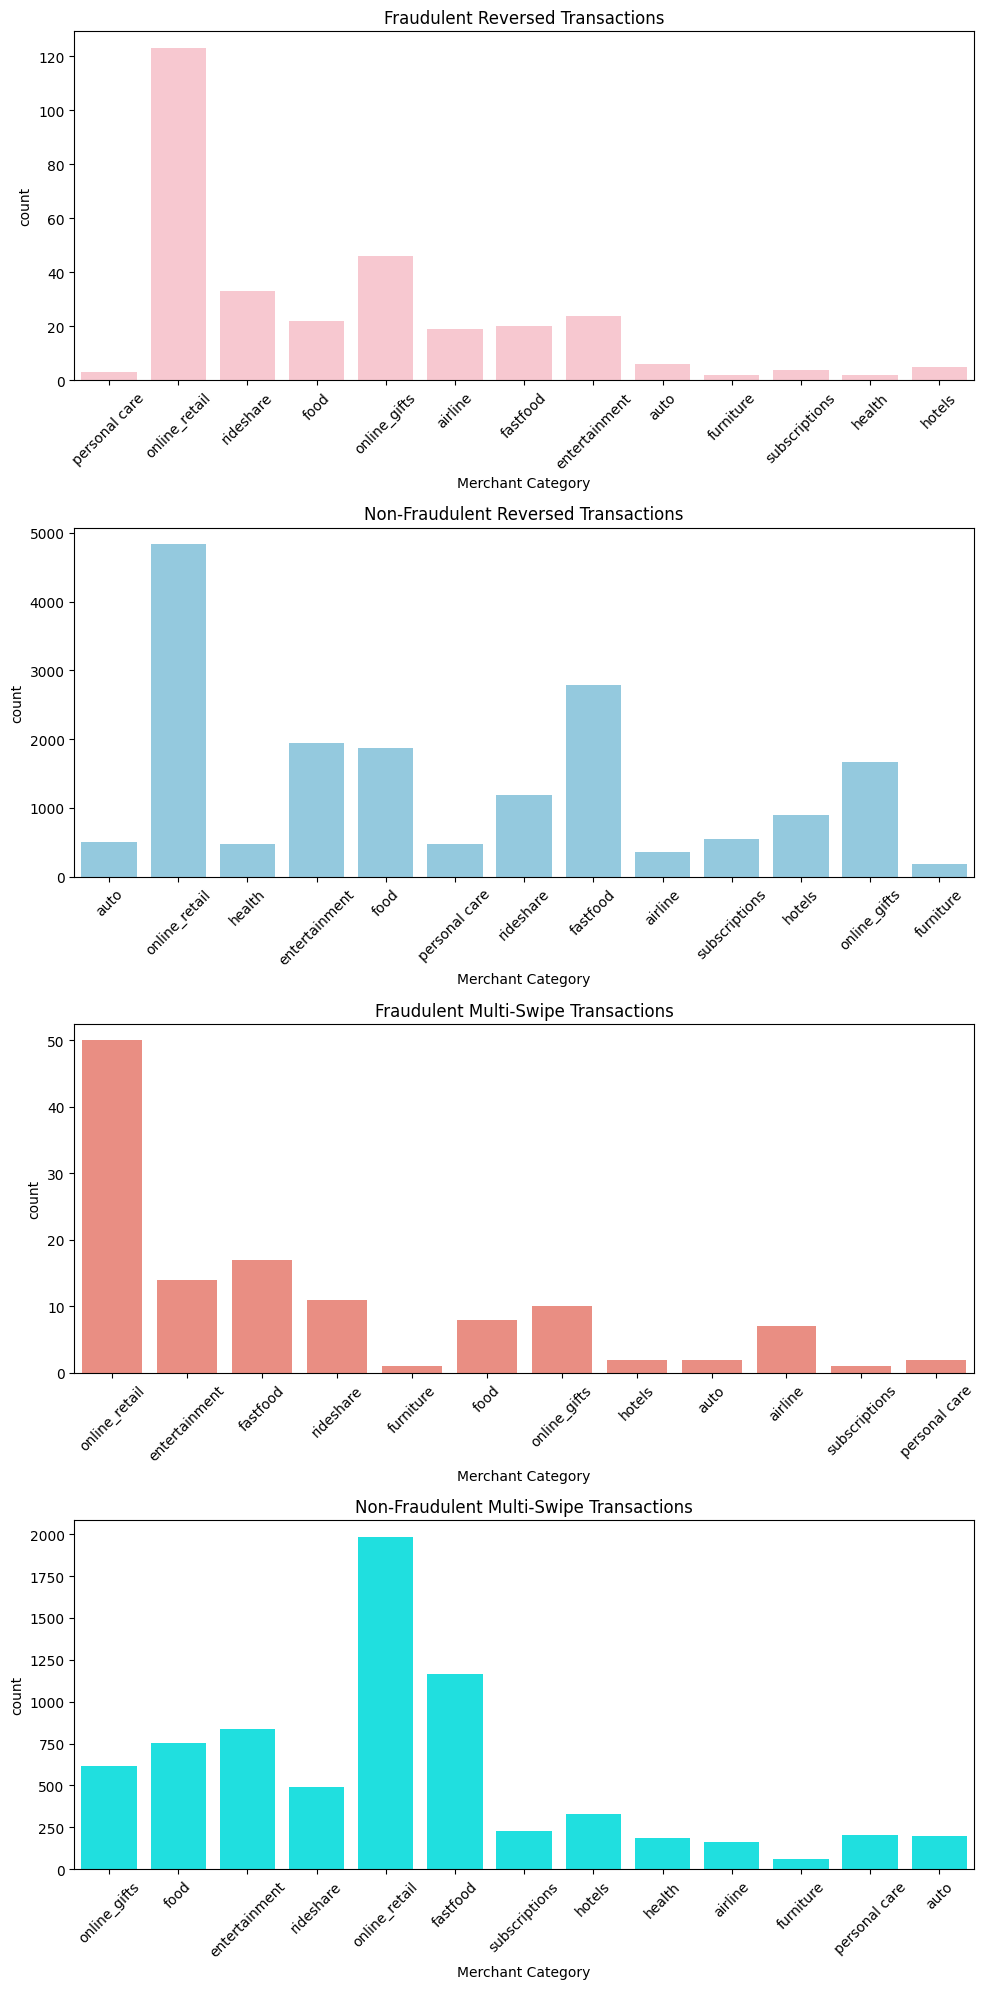

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

sns.countplot(data = reversed_trans[reversed_trans['isFraud_y'] == True],
              x= 'merchantCategoryCode_y', color="pink", ax=axes[0])
axes[0].set_title("Fraudulent Reversed Transactions")
axes[0].set_xlabel('Merchant Category')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data = reversed_trans[reversed_trans['isFraud_y'] == False],
              x= 'merchantCategoryCode_y', color="skyblue", ax=axes[1])
axes[1].set_title("Non-Fraudulent Reversed Transactions")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Merchant Category')

sns.countplot(data = multi_trans_final[multi_trans_final['isFraud'] == True],
              x= 'merchantCategoryCode', color="salmon", ax=axes[2])
axes[2].set_title("Fraudulent Multi-Swipe Transactions")
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_xlabel('Merchant Category')

sns.countplot(data = multi_trans_final[multi_trans_final['isFraud'] == False],
              x= 'merchantCategoryCode', color="aqua", ax=axes[3])
axes[3].set_title("Non-Fraudulent Multi-Swipe Transactions")
axes[3].tick_params(axis='x', rotation=45)
axes[3].set_xlabel('Merchant Category')

fig.tight_layout()

In [ ]:
# * Change file path to your directory if necessray *
df.to_csv('transactions_part3_processed.csv', index = False)
unique_reversed_trans.to_csv('reversed_transactions.csv', index = False)
multi_trans_final.to_csv('multi_swipe_transactions.csv', index = False)

## **Part 4: Modeling**

Part 4 draws insights from previous parts and incorporate them into the predictive model for frauds. Before doing that, we load the appropriate data:

In [450]:
# *Change the file path to your file directory if necessary*
file_path1 = 'transactions_part3_processed.csv'
file_path2 = 'multi_swipe_transactions.csv'
file_path3 = 'reversed_transactions.csv'

# Load processed data from part 3
df = pd.read_csv(file_path1)
multi_trans_df = pd.read_csv(file_path2)
unique_reversed_trans = pd.read_csv(file_path3)

### 4.1 Data Pre-Processing

#### 4.11 Binary Variables

Based on Part 3, we decided that we should remove duplicated transactions because it not only affects data quality, but also it appears that it does not introduce additional insights about fraud detection.

In [451]:
# Tagging the muti-swipe transaction ids
multi_trans_unique = pd.DataFrame(multi_trans_df['transaction_id'].unique())
multi_trans_unique['multi_swipe_trans'] = 1

# Tagging the reversed transaction ids
# reversed_trans_unique_x = pd.DataFrame(reversed_trans_df['transaction_id_x'].unique())
reversed_trans_unique = pd.DataFrame(unique_reversed_trans['transaction_id_y'].unique())
# reversed_trans_unique = pd.concat([reversed_trans_unique_x, reversed_trans_unique_y], ignore_index=True)
reversed_trans_unique['reversed_trans'] = 1

# Matching transaction ids from the original dataframe to the tags
df = pd.merge(df, multi_trans_unique, how ='left', left_on = 'transaction_id',
              right_on = 0)
df = pd.merge(df, reversed_trans_unique, how ='left', left_on = 'transaction_id', right_on = 0)

# Replace NaN with 0 to construct the indicator variables
df['multi_swipe_trans'].fillna(value = 0, inplace = True)
df['reversed_trans'].fillna(value = 0, inplace = True)

# Drop unnecessary columns
df.drop(axis = 1, columns = ['0_x', '0_y'], inplace = True)

# Drop duplicated transactions
df_duplicate_dropped = df[(df['multi_swipe_trans'] == 0) & (df['reversed_trans'] == 0)]

In previous parts, I have created booleans for the identifier variables I found telltaling:


*   ```weird_digits```: whether ```cardLast4Digits``` recorded a number that is not 4 digits
*   ```CVV_matched```: whether entered CVV matches actual CVV.

In this part, I converted all the default boolean variables and the created variables above into binary values. 

In [452]:
# Construct a list of binary variables
binary_vars = ['cardPresent', 'expirationDateKeyInMatch', 'weird_digits',
               'CVV_matched', 'multi_swipe_trans', 'reversed_trans']

# Convert them to indicators
for var in binary_vars:
    df_duplicate_dropped[var] = df_duplicate_dropped[var].astype(int)

#### 4.12 Categorical Variables with Missing Values Processed

As demonstrated in Part 1, all the missing values come from categorical variables. In order to deal with massive categorical features and missing values, I decided to use Catboost as my predictive model for this task.

A previous method I attempted is one-hot encoding with XGBoost and Logistic Regression - it didn't work well because of the categorical nature of our dataset. Catboost is able to capture complex relationships between categorical features that one-hot encoding cannot, and therefore is favorable for our predictive task. 

In [453]:
categorical_vars = ['acqCountry', 'merchantCountryCode', 'posEntryMode',
                    'posConditionCode', 'merchantCategoryCode', 'transactionType']

for var in categorical_vars:
    df_duplicate_dropped[var] = df_duplicate_dropped[var].astype(str)

# df_duplicate_dropped[categorical_vars] = df_duplicate_dropped[categorical_vars].fillna('missing').astype(str)

df_encoded = df_duplicate_dropped.copy()

# Failed attempts -- one hot encoding
# # Define a column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(sparse=False), categorical_vars)
#     ],
#     remainder='passthrough'  # Keep the other columns unchanged
# )

# # Apply the column transformer
# encoded_data = preprocessor.fit_transform(df_duplicate_dropped)

# # Get feature names from the one-hot encoder and append the names of the passthrough columns
# encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
# all_columns = encoded_columns.tolist() + [col for col in df_duplicate_dropped.columns if col not in categorical_vars]

# # Convert to DataFrame
# df_encoded = pd.DataFrame(encoded_data, columns=all_columns)

#### 4.13 Date-Time Variables

I extracted the year, month, day, hour, minute, second from all the date-time variables whenever available, given that, based on previous time series plots, there is a chance that timestamp variables would be of great importance.

In [455]:
# Construct a list of date-time variables
date_vars = ['transactionDateTime', 'currentExpDate', 'accountOpenDate',
             'dateOfLastAddressChange']

# For each date-time variable, retrieve their year, month, day
for var in date_vars:
  df_encoded[f'{var}_year'] = pd.to_datetime(df_encoded[var]).dt.year
  df_encoded[f'{var}_month'] = pd.to_datetime(df_encoded[var]).dt.month
  df_encoded[f'{var}_day'] = pd.to_datetime(df_encoded[var]).dt.day

# For transaction date-time variable, additionally retrieve hour, minute, second
df_encoded['transactionDateTime_hour'] = pd.to_datetime(df_encoded['transactionDateTime']).dt.hour
df_encoded['transactionDateTime_min'] = pd.to_datetime(df_encoded['transactionDateTime']).dt.minute
df_encoded['transactionDateTime_second'] = pd.to_datetime(df_encoded['transactionDateTime']).dt.second

#### 4.14 Numerical Variables

I did not pre-process ```creditLimit``` because of its unique ability to measure credit limit and categorize entries into respective groups. I wanted to keep it as it is, to preserve its ordinality and its grouping function. 

For ```availableMoney```, since it is heavily skewed to the right while containing negative values, I applied the Yeo-Johnson transformation to it, which deals with both skewness and negativity.

For the other 2 variables, as demonstrated in Part 2, they are heavily skewed to the right. Hence, I performed log transformation on these variables. Given their sparse nature, I also created an additional binary variable for each of the 2 variables to determine whether the value is equal to 0 or not, as being 0 itself might be a useful indicator to differentiate between transactions. 

In [456]:
# Construct a list of numerical variables
numeric_vars = ['transactionAmount', 'currentBalance']

# Apply Yeo-Johnson transformation to handle skewness with negative values
pre_transform_col = df_encoded[['availableMoney']]
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
post_transform_col = yeo_johnson_transformer.fit_transform(pre_transform_col)
df_encoded['availableMoney_transformed'] = post_transform_col

for var in numeric_vars:
  df_encoded[f'{var}_log'] = np.log(df_encoded[var].astype(float)+1)
  df_encoded[f'{var}_is_zero'] = (df_encoded[var] == 0).astype(int)

From the plots below, we can see that the data skewness has been improved for ```transactionAmount``` and ```currentBalance```. ```availableMoney``` is still quite skewed - but we cannot log it due to the fact that it contains negative values. Hence, one way to mitigate this is to use tree-based models.  

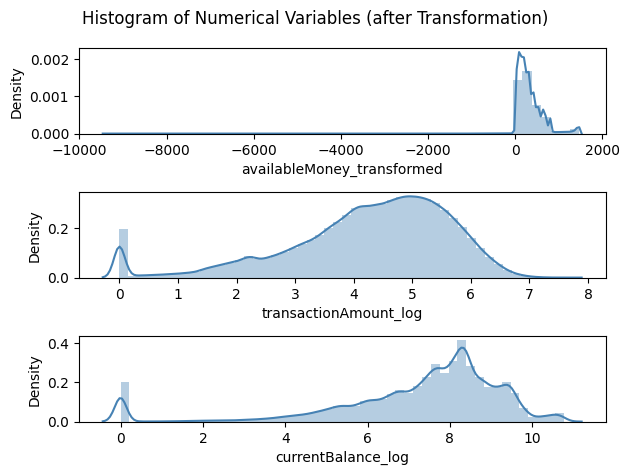

In [446]:
fig, axes = plt.subplots(nrows = 3, ncols = 1)

sns.distplot(df_encoded['availableMoney_transformed'], kde = True, color = 'steelblue', ax=axes[0])
sns.distplot(df_encoded['transactionAmount_log'], kde = True, color = 'steelblue', ax=axes[1])
sns.distplot(df_encoded['currentBalance_log'], kde = True, color = 'steelblue', ax=axes[2])

plt.suptitle('Histogram of Numerical Variables (after Transformation)')
fig.subplots_adjust(top = 0.95)
fig.tight_layout()

#### 4.15 Correlation between Features

After dropping the redundant variables, I plotted a correlation heatmap to see if multicollinearity problem persists. From the heatmap below, we can see that most variables are fairly independent of one another, albeit small numbers of variables exhibiting high correlations. Hence, to be cautious, we might want to use tree-based model that are immune to multicollinearity. 

In [457]:
# Dropping redundant features after pre-processing the data
features_to_drop = ['accountNumber', 'customerId', 'transaction_id',
                    'availableMoney', 'transactionDateTime', 'transactionAmount',
                    'merchantName', 'currentExpDate', 'accountOpenDate', 'currentBalance',
                    'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits']

df_encoded.drop(axis = 1, columns = features_to_drop, inplace = True)
# df_encoded = df_encoded.astype(float)

<Axes: >

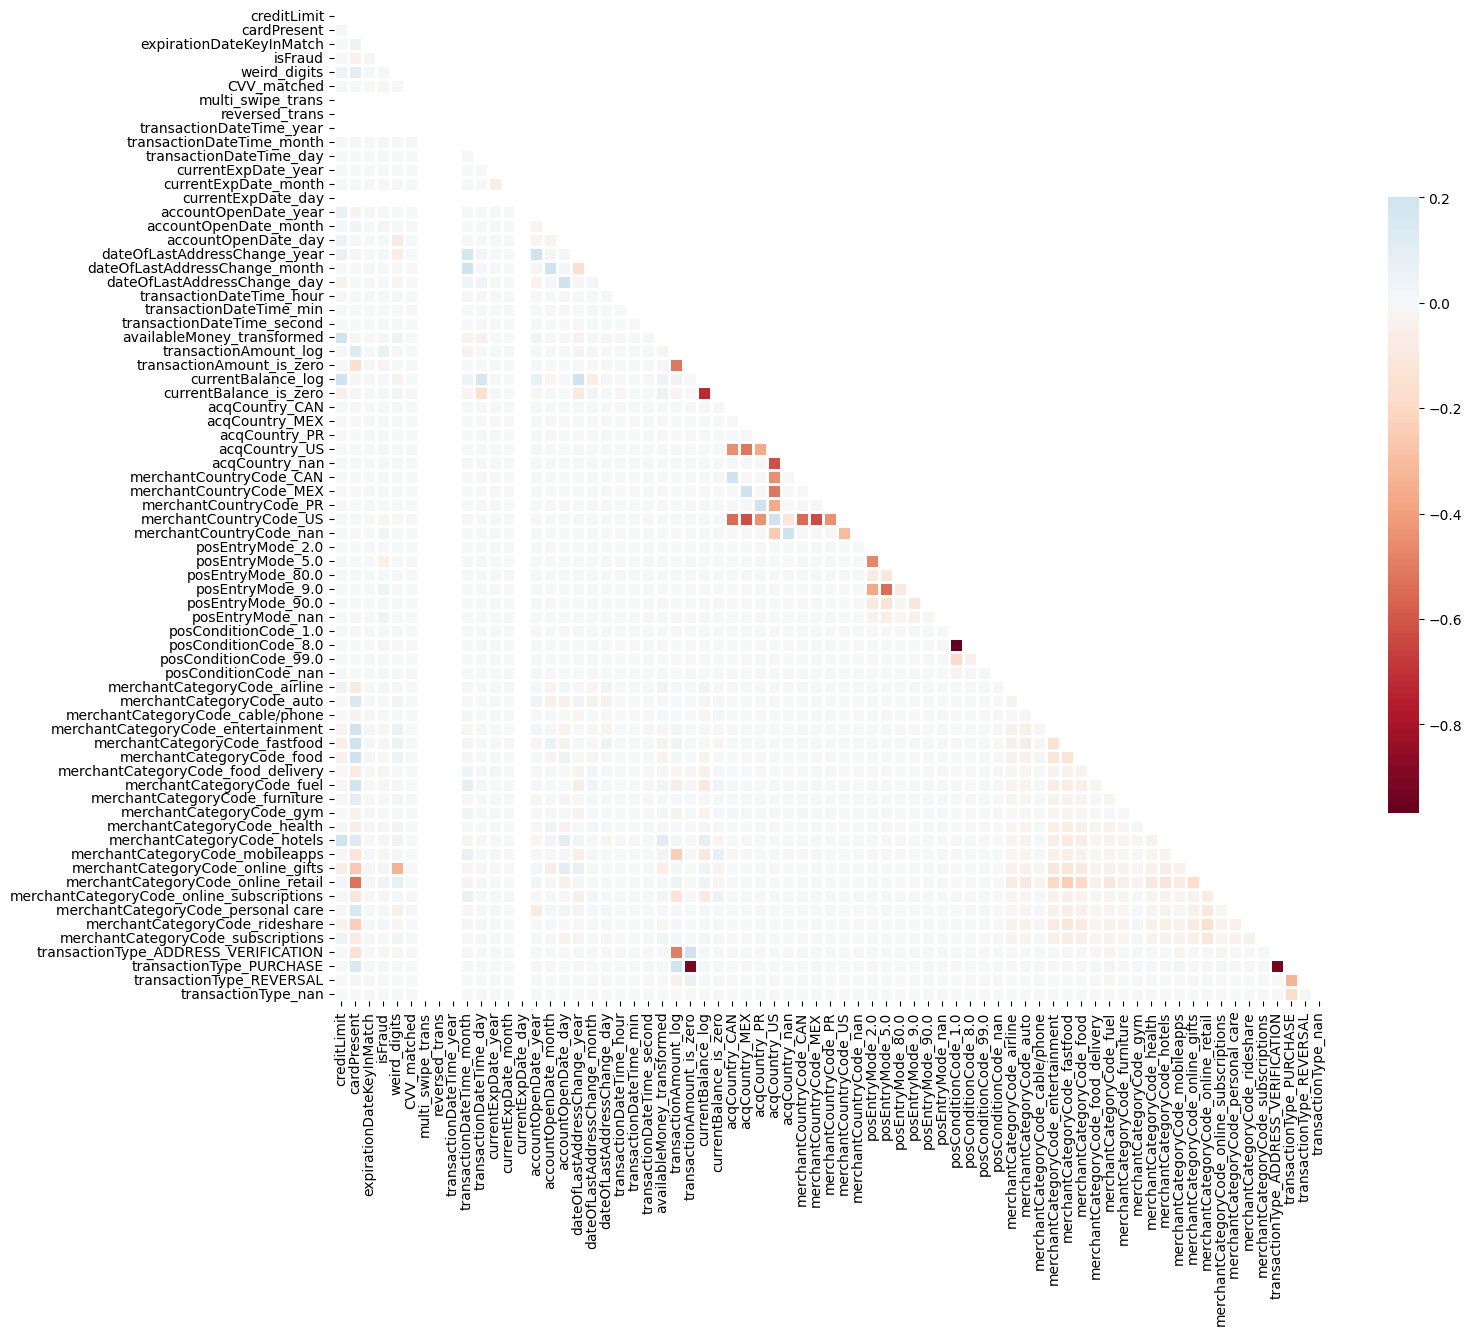

In [448]:
# Plotting correlations
df_corr = pd.get_dummies(df_encoded)
corr = df_corr.corr(method='pearson')
plt.figure(figsize=(16, 16))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns,cmap = "RdBu", annot = False, fmt = ".2f",
    vmax=.2, center = 0, square = True, linewidths = 1, cbar_kws = {"shrink": .5})

### 4.2 Train / Test Data Preparation

#### 4.21 Train-test split

Since the data is highly imbalanced, I conducted stratified train-test split to ensure that the train and the test datasets have the same proportion of target classes as in the original dataset. Then I standardized the numerical features in the dataset.

A method that I attempted but failed was winsorization to smooth outliers (i.e., smoothing max values with 95 percentile and min values with 5 percentile), since tree-based model is insensitive to outliers.

In [426]:
# Separate the features from the target
features = df_encoded.copy()
# features = df_encoded.drop('isFraud', axis=1)
target = df_encoded['isFraud']

# Split the data - 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify = target, random_state=1234)

In [428]:
numeric_cols = ['transactionAmount_log', 'currentBalance_log', 'availableMoney_transformed',
                'creditLimit']

# Standardize numeric columns
scaler = StandardScaler()

# Winsorize outliers and standardize numeric columns for train and test separately
for col in numeric_cols:
    # X_train[col] = mstats.winsorize(X_train[col], limits=[0.05, 0.05]) ## Failed attempt
    # X_test[col] = mstats.winsorize(X_test[col], limits=[0.05, 0.05])
    X_train[[col]] = scaler.fit_transform(X_train[[col]])
    X_test[[col]] = scaler.transform(X_test[[col]])

#### 4.22 Data Resampling

To tackle imbalance data, I further resampled the dataset separately to ensure that the number of ```True``` and ```False``` instances are equal in each dataset. This allows the machine learning model to focus more on detecting fraud instances (rather than predicting non-frauds). Another way to deal with imbalanced dataset is to use SMOTE, which interpolates minority class samples and generates synthetic samples. The reason why I didn't use SMOTE is because it oversamples the minority class, hence increasing the time needed to run the model.

In [429]:
# Separate positive and negative classes in the training set
neg_train = X_train[X_train['isFraud'] == 0]
neg_train = neg_train.drop('isFraud', axis=1)
pos_train = X_train[X_train['isFraud'] == 1]
pos_train = pos_train.drop('isFraud', axis=1)

# Sample 8600 examples from both classes
pos_train_over = pos_train.sample(25000, replace=True)
neg_train_sample = neg_train.sample(25000)

# Combine the sampled data
X_train_res = pd.concat([pos_train_over, neg_train_sample], axis=0)
y_train_res = pd.concat([pd.Series([1]*25000), pd.Series([0]*25000)], axis=0)

# Separate positive and negative classes in the test set
neg_test = X_test[X_test['isFraud'] == 0]
pos_test = X_test[X_test['isFraud'] == 1]

# Sample 3700 examples from both classes
pos_test_over = pos_test.sample(10000, replace=True)
neg_test_sample = neg_test.sample(10000)

# Combine the sampled data
X_test = pd.concat([pos_test_over, neg_test_sample], axis=0)
y_test = pd.concat([pd.Series([1]*10000), pd.Series([0]*10000)], axis=0)

X_test = X_test.drop('isFraud', axis=1)
# Note: I tried modeling by not resampling the test data as well, 
# but accuracy and recall did not change much - precision reasonably went down a bit

### 4.3 Model Training

#### 4.31 CatBoost

I decided to use CatBoost because:

- CatBoost is a tree-based model which can be used to avoid effect of outliers on the predicted results - this helps mitigate outliers observed in the data.

- Boosting techniques with built-in regularization can be used to improve accuracy while avoid overfitting.

- CatBoost can handle categorical features and capture complex relationship within the features naturally, without the need for one-hot encoding or label encoding, unlike XGBoost which requires manual handling. Therefore, CatBoost helps handle the massive categorical features in our data.
  
- CatBoost can naturally handle missing values without the need for imputation techniques, unlike XGBoost which requires manual imputation - this helps handling the missing values in our data.

For hyperparamter tuning, I used grid search CV because it allows for more thorough exploration of all possible combinations over a predefined parameter space than randomized CV. For future improvement, it would be better to use randomized CV first and then refining the search space with a grid search around promising regions.

In [430]:
# Define hyperparameter range
param_grid_cb = {
    'depth': [8],
    'learning_rate': [0.2],
    'iterations': [100]
}

# Create a catboost model
cb_model = CatBoostClassifier()

# Create GridSearch CV instance
cb_grid = GridSearchCV(estimator=cb_model,
                       param_grid=param_grid_cb,
                       scoring='roc_auc',
                       cv=3,
                       n_jobs=-1)

# Fit data with the hyperparameters
cb_grid.fit(X_train_res, y_train_res, cat_features = categorical_vars)

# Find the best parameter and model
print(cb_grid.best_params_)
best_cb = cb_grid.best_estimator_

# Predict the test data
pred_cb = best_cb.predict(X_test)

0:	learn: 0.6565792	total: 232ms	remaining: 23s
1:	learn: 0.6342774	total: 468ms	remaining: 23s
2:	learn: 0.6146115	total: 668ms	remaining: 21.6s
3:	learn: 0.6031803	total: 820ms	remaining: 19.7s
4:	learn: 0.5864752	total: 974ms	remaining: 18.5s
5:	learn: 0.5755011	total: 1.15s	remaining: 18.1s
6:	learn: 0.5653938	total: 1.33s	remaining: 17.7s
7:	learn: 0.5586746	total: 1.52s	remaining: 17.5s
8:	learn: 0.5551998	total: 1.71s	remaining: 17.3s
9:	learn: 0.5505719	total: 1.94s	remaining: 17.4s
10:	learn: 0.5469022	total: 2.09s	remaining: 16.9s
11:	learn: 0.5427402	total: 2.3s	remaining: 16.9s
12:	learn: 0.5401326	total: 2.49s	remaining: 16.7s
13:	learn: 0.5381200	total: 2.71s	remaining: 16.7s
14:	learn: 0.5364309	total: 2.85s	remaining: 16.2s
15:	learn: 0.5349753	total: 3.04s	remaining: 16s
16:	learn: 0.5331958	total: 3.3s	remaining: 16.1s
17:	learn: 0.5308487	total: 3.47s	remaining: 15.8s
18:	learn: 0.5279469	total: 3.7s	remaining: 15.8s
19:	learn: 0.5253491	total: 3.95s	remaining: 15.8s

The feature importance table below supported the hypotheses we made in previous parts. Merchant categories played the most significant role in fraud detection, while the time trend we observed for ```accountOpenDate``` in Part 2 also proved to be informative in fraud detection. As expected, ```posEntryMode``` is an important feature to determine transaction frauds. Numerical variables, such as ```creditLimit```and ```currentBalance``` also play a moderately important role in fraud detection. 

In [473]:
# Concat a table for feature importance
feature_importances=pd.DataFrame(cb_grid.best_estimator_.get_feature_importance(),columns=['importance'])
feature=pd.DataFrame(X_train_res.columns,columns=['feature'])
o=pd.concat([feature_importances,feature],axis=1)
print(o.sort_values('importance', ascending = False))


    importance                        feature
5    15.237078           merchantCategoryCode
21    9.262330            accountOpenDate_day
29    9.023098          transactionAmount_log
20    7.788788          accountOpenDate_month
3     7.484815                   posEntryMode
0     5.402178                    creditLimit
19    5.249433           accountOpenDate_year
31    4.296675             currentBalance_log
7     3.587727                    cardPresent
28    3.074535     availableMoney_transformed
24    3.054445    dateOfLastAddressChange_day
26    3.003917        transactionDateTime_min
25    2.986508       transactionDateTime_hour
27    2.804187     transactionDateTime_second
23    2.731697  dateOfLastAddressChange_month
16    2.524894            currentExpDate_year
14    2.428039      transactionDateTime_month
22    2.318951   dateOfLastAddressChange_year
15    2.215728        transactionDateTime_day
17    2.210495           currentExpDate_month
4     1.428754               posCo

#### 4.32 Model Evaluation

Given that this is a classification task, we use accuracy, precision, recall, and F1 score to evaluate our model performance. Given the threat that a single fraud can cause to users (huge monetary losses), we are more concerned about the recall (the ability to identify fraud when there is one) than the accuracy. We are also concerned about precision (although not as much as recall) because we do not want to burden credit card users with false fraud alerts, which will lead to a drop in customer base in the long run. 

The CatBoost model coupled with resampling techniques generated fairly favorable outcome on recall (0.68), precision (0.75), and F1 score (0.73) at the expense of accuracy (accuracy of blindly guessing non-fraud is about 98.42%), but doing so aligns with our goal for this project, which is to detect fraud. 

In [469]:
# Print accurancy, recall, precision, f1
acc=accuracy_score(y_test.astype(int), pred_cb)
print('Accuracy =' ,acc)

recall = recall_score(y_test.astype(int), pred_cb)
print('Recall =' , recall)

precision = precision_score(y_test.astype(int), pred_cb)
print('Precision =' , precision)

f1score = f1_score(y_test.astype(int), pred_cb, average='macro')
print('F1 Score : ', f1score)


Accuracy = 0.72685
Recall = 0.6826
Precision = 0.7488754799780581
F1 Score :  0.7263141059140112


Confusion Matrix
  |    0    1 |
--+-----------+
0 |<7711>2289 |
1 | 3174<6826>|
--+-----------+
(row = reference; col = test)



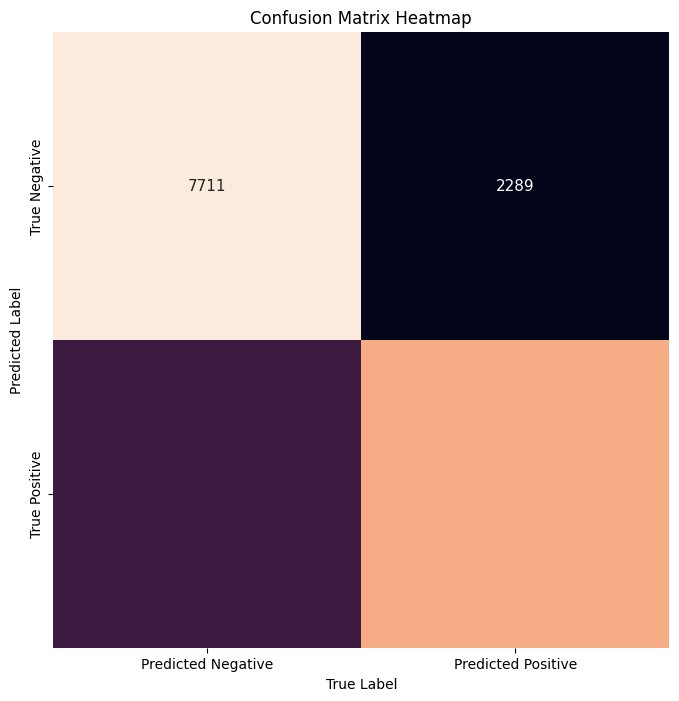

In [499]:
# Print confusion matrix
print('Confusion Matrix')
print(ConfusionMatrix(list(y_test), list(pred_cb)))

# Create and plot a confusion
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(list(y_test), list(pred_cb)), annot= True, fmt='d', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'], square = True, 
            annot_kws={"size": 11})
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix Heatmap')
plt.show()




Another evaluation method for model performance is the ROC curve. From the plot below, the AUC (area under curve) is 0.8, which is considered to be an acceptable score.

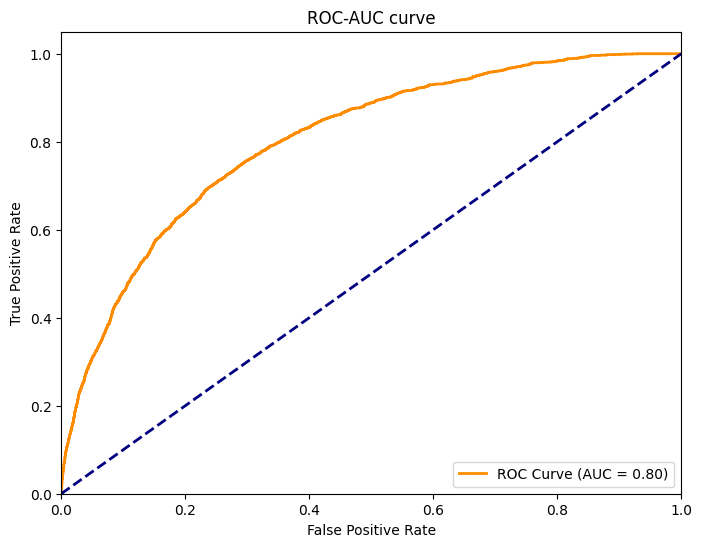

In [496]:
# Plot ROC-AUC curve
probabilities = best_cb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Plot ROC-AUC graph
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, probabilities))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend(loc="lower right")
plt.show()

#### 4.33 Future Improvements

The first critical aspect of improvement is to implement a feature selection process, since the quality and relevance of features significantly impact a model's performance. One approach is to employ techniques like Elastic Net regression, which combines the strengths of L1 (Lasso) and L2 (Ridge) regularization, striking a balance between feature selection and coefficient shrinkage. By doing so, it not only helps in identifying the most relevant features but also mitigates the risk of overfitting. This feature selection method is particularly useful when dealing with high-dimensional datasets with feature redundancy and noise.

Additionally, for feature engineering, it is worth considering techniques like aggregation and decomposition, as they may provide valuable insights and enhance the informativeness of the features.

Moreover, it is often advantageous to evaluate the performance of different machine learning models before settling on one model. Therefore, a more cautious approach is to compare the results obtained from various models and pick the one that has the best performance. This comparative analysis provides valuable insights into the strengths and weaknesses of each model on different tasks.

We should also consider stratified clustering based on account number, since we showed that frauds tend to cluster by account / customer.

Finally, emsemble stratgies can be deployed: models can be combined together into, for example, a voting classifer. Doing so may leverage the advantages of different models to fill in the gaps that a single model might be struggling with. 